In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [41]:
from local_explanations import *
import utils
import models

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np

import torch
import torch_geometric.transforms as T
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split

from collections import defaultdict

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### read data

In [3]:
DATASET_NAME = "BAMultiShapes2"

In [4]:
adjs_train , \
edge_weights_train , \
ori_classes_train , \
belonging_train , \
summary_predictions_train , \
le_classes_train = read_bamultishapes2(evaluate_method=True, 
                                       remove_mix=False, 
                                       min_num_include=5, 
                                       split="TRAIN") #, manual_cut=0.47377795

print(len(adjs_train) , len(edge_weights_train), len(ori_classes_train) , len(belonging_train))
print(np.unique(summary_predictions_train["wrong"], return_counts=True) , np.unique(summary_predictions_train["correct"], return_counts=True))
print(np.unique(le_classes_train, return_counts=True))

Num shapes: 909, Num Preserved: 901, Ratio: 0.991, Num Multipleshapes: 240
num_class_relationship_broken:  7  num_multi_shapes_removed: 0
912 912 754 912
(array([1, 5, 7]), array([ 6,  3, 37], dtype=int64)) (array([0, 1, 2, 3, 4, 5, 6]), array([ 34,  36,  45, 242, 124, 136, 137], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6]), array([117, 153, 151, 251,  73,  97,  70], dtype=int64))


In [5]:
adjs_val , \
edge_weights_val , \
ori_classes_val , \
belonging_val , \
summary_predictions_val , \
le_classes_val = read_bamultishapes2(evaluate_method=True, 
                                     remove_mix=False, 
                                     min_num_include=5, 
                                     split="VAL") #, manual_cut=0.47377795

print(len(adjs_val) , len(edge_weights_val), len(ori_classes_val) , len(belonging_val))
print(np.unique(summary_predictions_val["wrong"], return_counts=True) , np.unique(summary_predictions_val["correct"], return_counts=True))
print(np.unique(le_classes_val, return_counts=True))

Num shapes: 113, Num Preserved: 113, Ratio: 1.0, Num Multipleshapes: 38
num_class_relationship_broken:  0  num_multi_shapes_removed: 0
106 106 94 106
(array([1, 7]), array([2, 4], dtype=int64)) (array([0, 1, 2, 3, 4, 5, 6]), array([ 2,  4,  7, 31, 10, 20, 20], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 9, 11, 17, 31,  8, 15, 15], dtype=int64))


In [6]:
adjs_test , \
edge_weights_test , \
ori_classes_test , \
belonging_test , \
summary_predictions_test , \
le_classes_test = read_bamultishapes2(evaluate_method=True, 
                                      remove_mix=False, 
                                      min_num_include=5, 
                                      split="TEST") #, manual_cut=0.47377795

print(len(adjs_test) , len(edge_weights_test), len(ori_classes_test) , len(belonging_test))
print(np.unique(summary_predictions_test["wrong"], return_counts=True) , np.unique(summary_predictions_test["correct"], return_counts=True))
print(np.unique(le_classes_test, return_counts=True))

Num shapes: 118, Num Preserved: 117, Ratio: 0.992, Num Multipleshapes: 31
num_class_relationship_broken:  1  num_multi_shapes_removed: 0
119 119 99 119
(array([1]), array([1], dtype=int64)) (array([0, 1, 2, 3, 4, 5, 6]), array([ 7,  4,  7, 31, 17, 14, 19], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6]), array([17, 20, 18, 33,  9, 11, 11], dtype=int64))


### dataset

C:\Users\Steve\Desktop\GNN\gnn_logic_global_expl\code\utils.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_attr=torch.tensor(t.weight).reshape(-1, 1),


(array([0, 1, 2, 3, 4, 5, 6]), array([117, 153, 151, 251,  73,  97,  70], dtype=int64))
(tensor([0, 1]), tensor([365, 547]))


('house+wheel', 11, tensor([11]))

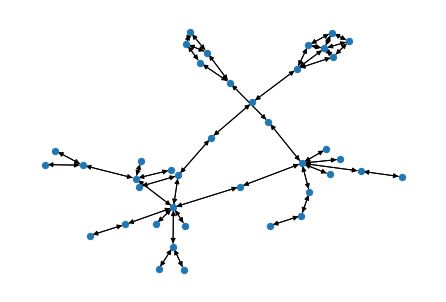

In [7]:
device = "cpu" #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = T.Compose([
    T.NormalizeFeatures(),
])     


dataset_train = utils.LocalExplanationsDataset("", adjs_train, edge_weights_train, "same", transform=transform, y=le_classes_train, belonging=belonging_train, task_y=ori_classes_train)
dataset_val = utils.LocalExplanationsDataset("", adjs_val, edge_weights_val, "same", transform=transform, y=le_classes_val, belonging=belonging_val, task_y=ori_classes_val)
dataset_test = utils.LocalExplanationsDataset("", adjs_test, edge_weights_test, "same", transform=transform, y=le_classes_test, belonging=belonging_test, task_y=ori_classes_test)


##
# debug Dataset
##
print(np.unique(le_classes_train, return_counts=True))
print(torch.unique(dataset_train.data.task_y, return_counts=True))
idx = 18
nx.draw(to_networkx(dataset_train[idx]), node_size=40)   # debug Dataset
bamultishapes2_classes_names[dataset_train[idx].y] , belonging_train[idx] , dataset_train[idx].graph_id

### Run the model

(array([0., 1., 2., 3., 4., 5., 6.], dtype=float32), array([117, 153, 151, 251,  73,  97,  70], dtype=int64))
[0.89611334 0.10120556]


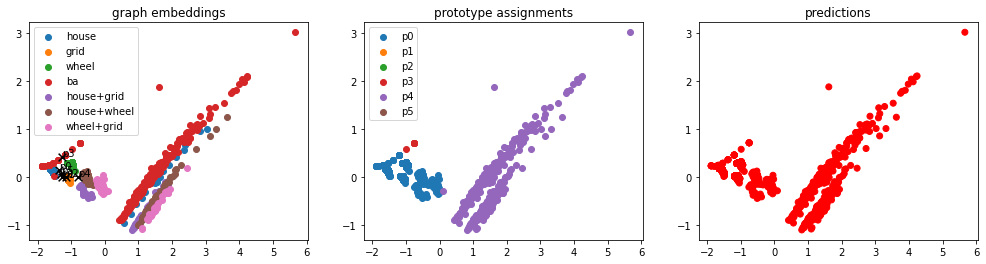

Alpha norms:
tensor([[0.9595, 1.0000, 0.9094, 0.7717, 0.9062, 0.8726],
        [0.8822, 0.8649, 0.8276, 1.0000, 0.9040, 0.7665]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.620723 +- 0.292133
Concept distribution:  (array([0, 3, 4], dtype=int64), array([529,   6, 377], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0

  1: Loss: 0.22270, LEN: 0.075827, AccxC: 0.50, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.29467, V. LEN 0.10
  2: Loss: 0.19953, LEN: 0.075510, AccxC: 0.51, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.26455, V. LEN 0.10
  3: Loss: 0.17137, LEN: 0.075200, AccxC: 0.52, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.23071, V. LEN 0.10
  4: Loss: 0.14998, LEN: 0.074889, AccxC: 0.50, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.19993, V. LEN 0.10
  5: Loss: 0.12980, LEN: 0.074545, AccxC: 0.55, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.17099, V. LEN 0.10
  6: Loss: 0.12041, LEN: 0.074241, AccxC: 0.53, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.16498, V. LEN 0.10


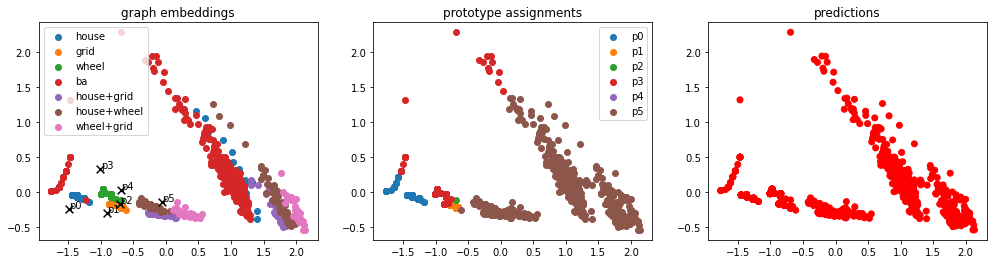

Alpha norms:
tensor([[0.9281, 0.9590, 0.8975, 0.7794, 0.8943, 1.0000],
        [0.7739, 0.6506, 0.7122, 1.0000, 0.8153, 0.7575]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.768880 +- 0.224935
Concept distribution:  (array([0, 1, 2, 3, 5], dtype=int64), array([118,  71,   1, 257, 465], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0

 20: Loss: 0.08042, LEN: 0.070056, AccxC: 0.51, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.11913, V. LEN 0.09
 21: Loss: 0.08207, LEN: 0.069769, AccxC: 0.53, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.11719, V. LEN 0.09
 22: Loss: 0.07897, LEN: 0.069331, AccxC: 0.53, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.11467, V. LEN 0.09
 23: Loss: 0.07776, LEN: 0.068973, AccxC: 0.53, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.11393, V. LEN 0.09
 24: Loss: 0.07730, LEN: 0.068632, AccxC: 0.54, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.11075, V. LEN 0.09
 25: Loss: 0.07736, LEN: 0.068434, AccxC: 0.50, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.109

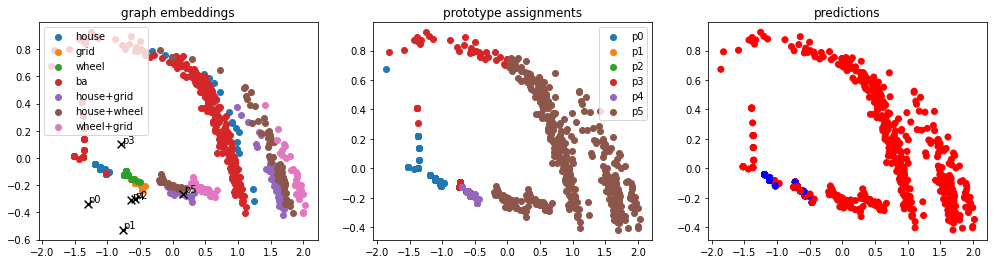

Alpha norms:
tensor([[0.8567, 0.9643, 0.8396, 1.0000, 0.9315, 0.9556],
        [1.0000, 0.6319, 0.7949, 0.7943, 0.6778, 0.9516]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.609053 +- 0.136174
Concept distribution:  (array([0, 3, 4, 5], dtype=int64), array([127, 214, 131, 440], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.5371352785145889 (feature003 & feature000) | (feature004 & feature000) | (feature000)
Accuracy as classifier:  0.0

 40: Loss: 0.07013, LEN: 0.064215, AccxC: 0.53, AccO: 0.13, V. Acc: 0.07, V. Loss: 0.10014, V. LEN 0.09
 41: Loss: 0.06974, LEN: 0.064137, AccxC: 0.53, AccO: 0.23, V. Acc: 0.53, V. Loss: 0.09860, V. LEN 0.09
 42: Loss: 0.06916, LEN: 0.064013, AccxC: 0.53, AccO: 0.44, V. Acc: 0.53, V. Loss: 0.09828, V. LEN 0.09
 43: Loss: 0.06872, LEN: 0.063851, AccxC: 0.53, AccO: 0.49, V. Acc: 0.53, V. Loss: 0.09972, V. LEN 0.09
 44: Loss: 0.06840, LEN: 0.063735, AccxC: 0.53, AccO: 0.50, V. Acc: 0.48, V. Loss: 0.09947, V. LEN 0.09
 45: Loss: 0.06

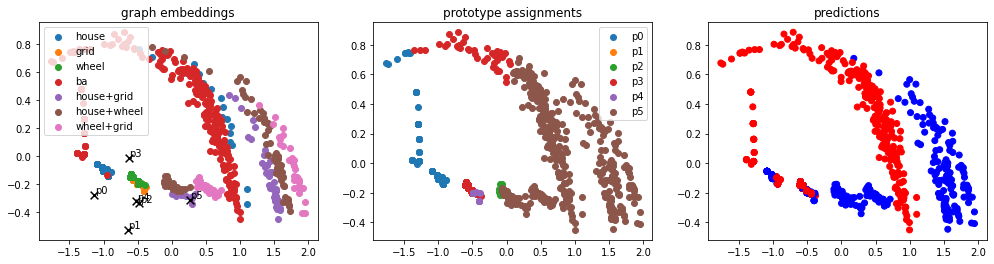

Alpha norms:
tensor([[0.6655, 0.8734, 0.8643, 1.0000, 0.8513, 0.4879],
        [1.0000, 0.8566, 0.8500, 0.5092, 0.9064, 0.8627]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.645896 +- 0.213637
Concept distribution:  (array([0, 2, 3, 4, 5], dtype=int64), array([140,   5, 332,  16, 419], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.5994694960212201 (feature002) | (feature005) | (feature004 & feature000) | ((feature003 & feature000) | ((feature003 & feature004) | (feature000)
Accuracy as classifier:  0.0

 60: Loss: 0.06679, LEN: 0.062933, AccxC: 0.60, AccO: 0.50, V. Acc: 0.49, V. Loss: 0.09413, V. LEN 0.08
 61: Loss: 0.06625, LEN: 0.062571, AccxC: 0.60, AccO: 0.52, V. Acc: 0.53, V. Loss: 0.09870, V. LEN 0.08
 62: Loss: 0.06609, LEN: 0.062452, AccxC: 0.62, AccO: 0.51, V. Acc: 0.49, V. Loss: 0.09264, V. LEN 0.08
 63: Loss: 0.06601, LEN: 0.062303, AccxC: 0.64, AccO: 0.51, V. Acc: 0.49, V. Loss: 0.09178, V. LEN 0.08
 64: Loss: 0.06548, LEN: 0.062142, AccxC: 0.60, Acc

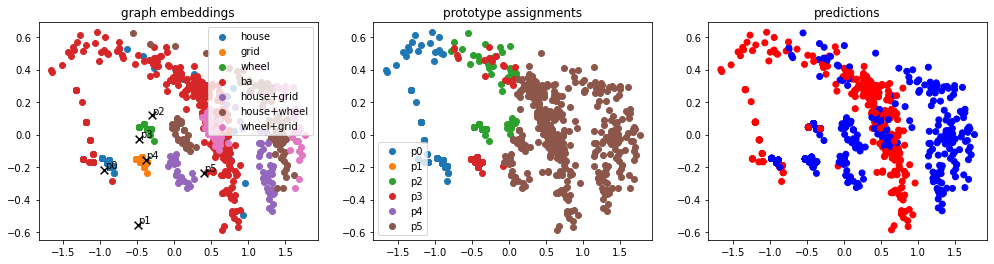

Alpha norms:
tensor([[0.6532, 0.6510, 0.9335, 1.0000, 0.8046, 0.2775],
        [0.5197, 0.8203, 0.6003, 0.2986, 0.9891, 1.0000]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.676823 +- 0.181670
Concept distribution:  (array([0, 2, 3, 5], dtype=int64), array([151, 195, 172, 394], dtype=int64))
Logic formulas:
For class 0:
0.6737400530503979 (feature003) | (feature000)
For class 1:
0.596816976127321 (feature002) | (feature005) | (feature000 & feature002) | ((feature003 & feature000) | ((feature003 & feature002) | (feature000)

------------------------------------------------------------------------------------
Has double activations  tensor(60)
But only for wrong predictions

Accuracy as classifier:  0.5955

 80: Loss: 0.06283, LEN: 0.060360, AccxC: 0.58, AccO: 0.58, V. Acc: 0.60, V. Loss: 0.09060, V. LEN 0.08
 81: Loss: 0.06340, LEN: 0.060796, AccxC: 0.57, AccO: 0.56, V. Acc: 0.60, V. Loss: 0.08991, V. LEN 0.08
 82: Loss: 0.06254, LEN: 0.059914, AccxC: 0.59, AccO: 0.58, V. Acc: 0.69

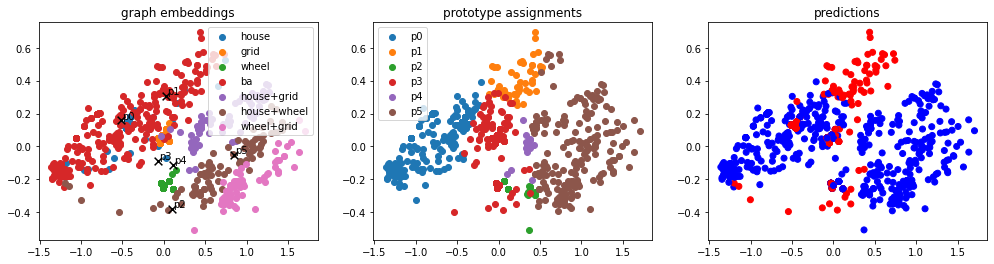

Alpha norms:
tensor([[0.8467, 0.5997, 1.0000, 0.9071, 0.8518, 0.2916],
        [0.1504, 0.2835, 0.3213, 0.1436, 0.6555, 1.0000]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.621695 +- 0.210114
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([266,  47,  38, 343,  19, 199], dtype=int64))
Logic formulas:
For class 0:
0.8846153846153846 (feature000) | (feature003) | (feature001)
For class 1:
0.786472148541114 (feature002) | (feature005) | (feature004) | (feature000 & feature002) | ((feature003 & feature002) | ((feature003 & feature004)
Accuracy as classifier:  0.7865

100: Loss: 0.04936, LEN: 0.047934, AccxC: 0.84, AccO: 0.73, V. Acc: 0.81, V. Loss: 0.06798, V. LEN 0.06
101: Loss: 0.04931, LEN: 0.047421, AccxC: 0.82, AccO: 0.74, V. Acc: 0.80, V. Loss: 0.06649, V. LEN 0.06
102: Loss: 0.04868, LEN: 0.046854, AccxC: 0.84, AccO: 0.72, V. Acc: 0.76, V. Loss: 0.06533, V. LEN 0.06
103: Loss: 0.04795, LEN: 0.046237, AccxC: 0.85, AccO: 0.73, V. Acc: 0.81, V. Loss: 0.06143

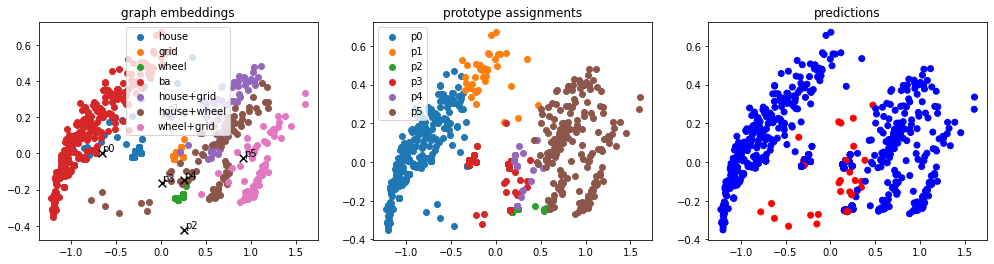

Alpha norms:
tensor([[1.0000, 0.5966, 0.9511, 0.7037, 0.9072, 0.5313],
        [0.0896, 0.0985, 0.2004, 0.1154, 0.3038, 1.0000]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.668924 +- 0.208029
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([268,  37, 129, 231,  42, 205], dtype=int64))
Logic formulas:
For class 0:
0.8607427055702918 (feature000) | (feature003) | (feature001)
For class 1:
0.8607427055702918 (feature005) | (feature002) | (feature004) | (feature003 & feature002) | (feature002 & feature004) | (feature003 & feature004) | ((feature000 & feature003) | ((feature000 & feature002) | ((feature000 & feature004)
Accuracy as classifier:  0.8607

120: Loss: 0.03584, LEN: 0.034313, AccxC: 0.84, AccO: 0.84, V. Acc: 0.88, V. Loss: 0.03870, V. LEN 0.03
121: Loss: 0.03353, LEN: 0.031971, AccxC: 0.85, AccO: 0.85, V. Acc: 0.88, V. Loss: 0.03865, V. LEN 0.04
122: Loss: 0.03418, LEN: 0.032462, AccxC: 0.84, AccO: 0.84, V. Acc: 0.88, V. Loss: 0.04072, V. LEN 0.04
123:

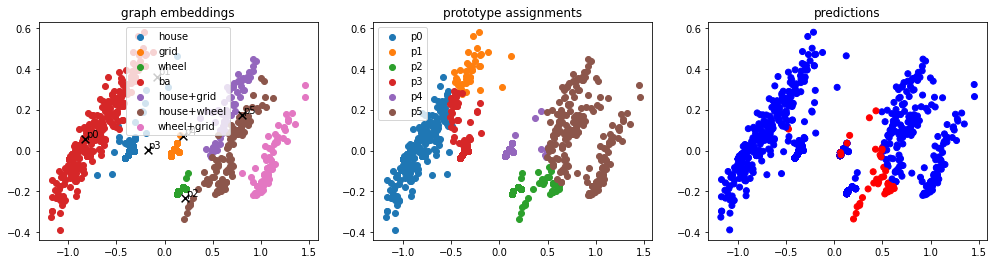

Alpha norms:
tensor([[1.0000, 0.4693, 0.7691, 0.6637, 0.7696, 0.5544],
        [0.0641, 0.0726, 0.1452, 0.0995, 0.1745, 1.0000]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.809166 +- 0.212102
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([193,  42, 182, 133, 163, 199], dtype=int64))
Logic formulas:
For class 0:
0.9363395225464191 (feature000) | (feature004) | (feature002) | ((feature001) | (feature003)
For class 1:
0.9018567639257294 (feature005) | (feature003 & feature004) | (feature002 & feature004) | (feature003 & feature002) | (feature004)

------------------------------------------------------------------------------------
Has double activations  tensor(46)
But only for wrong predictions

Accuracy as classifier:  0.8886

140: Loss: 0.02250, LEN: 0.021435, AccxC: 0.93, AccO: 0.86, V. Acc: 0.88, V. Loss: 0.02777, V. LEN 0.03
141: Loss: 0.02334, LEN: 0.022290, AccxC: 0.92, AccO: 0.86, V. Acc: 0.89, V. Loss: 0.02671, V. LEN 0.02
142: Loss: 0.02281, LEN: 0

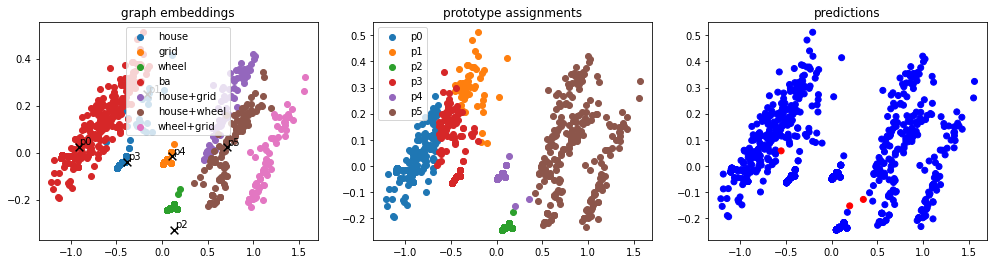

Alpha norms:
tensor([[1.0000, 0.4463, 0.7734, 0.7033, 0.7613, 0.6085],
        [0.0530, 0.0532, 0.1482, 0.0748, 0.1429, 1.0000]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.806120 +- 0.224168
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([145,  54, 150, 169, 155, 239], dtype=int64))
Logic formulas:
For class 0:
0.9880636604774535 (feature000) | (feature004) | (feature002) | ((feature001) | (feature003)
For class 1:
0.9880636604774535 (feature005) | (feature003 & feature004) | (feature004 & feature002) | (feature003 & feature002)
Accuracy as classifier:  0.9881

160: Loss: 0.01700, LEN: 0.016199, AccxC: 0.93, AccO: 0.93, V. Acc: 1.00, V. Loss: 0.01334, V. LEN 0.01
161: Loss: 0.01553, LEN: 0.014644, AccxC: 0.95, AccO: 0.95, V. Acc: 0.97, V. Loss: 0.01599, V. LEN 0.01
162: Loss: 0.01690, LEN: 0.016154, AccxC: 0.95, AccO: 0.95, V. Acc: 0.96, V. Loss: 0.01751, V. LEN 0.01
163: Loss: 0.01868, LEN: 0.017781, AccxC: 0.93, AccO: 0.93, V. Acc: 1.00, V. Loss: 0.01238

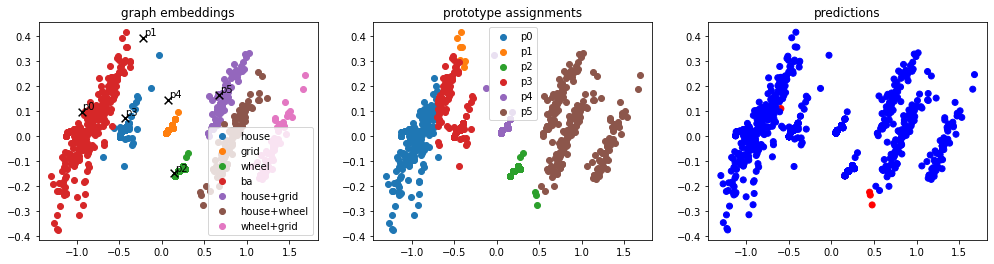

Alpha norms:
tensor([[1.0000, 0.4456, 0.8070, 0.7286, 0.7944, 0.6481],
        [0.0491, 0.0524, 0.1546, 0.0741, 0.1469, 1.0000]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.835663 +- 0.231482
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([184,   8, 154, 174, 155, 237], dtype=int64))
Logic formulas:
For class 0:
0.986737400530504 (feature000) | (feature004) | (feature002) | (feature003) | ((feature001)
For class 1:
0.986737400530504 (feature005) | (feature003 & feature004) | (feature004 & feature002) | (feature003 & feature002)
Accuracy as classifier:  0.9867

180: Loss: 0.01626, LEN: 0.015512, AccxC: 0.94, AccO: 0.94, V. Acc: 1.00, V. Loss: 0.00974, V. LEN 0.01
181: Loss: 0.01367, LEN: 0.012881, AccxC: 0.95, AccO: 0.95, V. Acc: 0.97, V. Loss: 0.01594, V. LEN 0.01
182: Loss: 0.01564, LEN: 0.014908, AccxC: 0.94, AccO: 0.94, V. Acc: 1.00, V. Loss: 0.01056, V. LEN 0.01
183: Loss: 0.01336, LEN: 0.012598, AccxC: 0.95, AccO: 0.95, V. Acc: 0.99, V. Loss: 0.01171, 

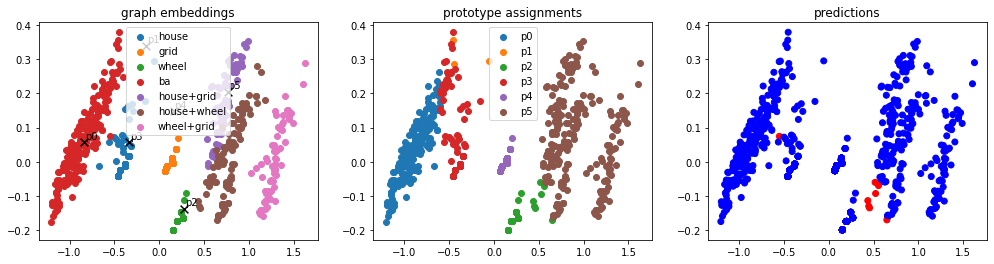

Alpha norms:
tensor([[1.0000, 0.4420, 0.8294, 0.7598, 0.8095, 0.6575],
        [0.0495, 0.0570, 0.1639, 0.0812, 0.1621, 1.0000]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.802334 +- 0.220411
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([223,   3, 158, 142, 153, 233], dtype=int64))
Logic formulas:
For class 0:
0.9814323607427056 (feature000) | (feature004) | (feature002) | (feature003) | ((feature001)
For class 1:
0.9814323607427056 (feature005) | (feature003 & feature004) | (feature004 & feature002) | (feature003 & feature002)
Accuracy as classifier:  0.9814

200: Loss: 0.01347, LEN: 0.012764, AccxC: 0.95, AccO: 0.95, V. Acc: 0.99, V. Loss: 0.00996, V. LEN 0.01
201: Loss: 0.01197, LEN: 0.011237, AccxC: 0.96, AccO: 0.96, V. Acc: 0.97, V. Loss: 0.01482, V. LEN 0.01
202: Loss: 0.01283, LEN: 0.011982, AccxC: 0.95, AccO: 0.95, V. Acc: 0.98, V. Loss: 0.01246, V. LEN 0.01
203: Loss: 0.01092, LEN: 0.010207, AccxC: 0.96, AccO: 0.96, V. Acc: 0.97, V. Loss: 0.01433

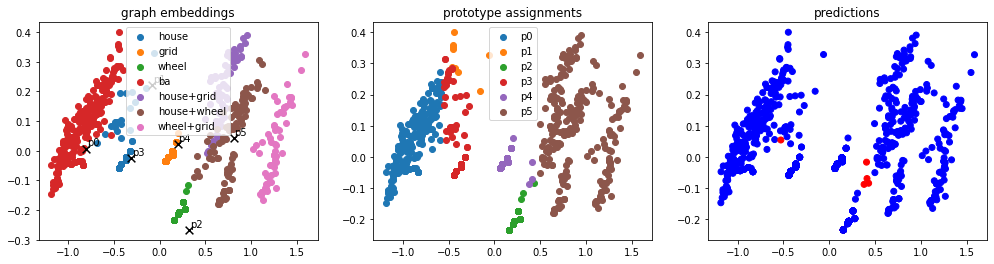

Alpha norms:
tensor([[1.0000, 0.4457, 0.8317, 0.7645, 0.8135, 0.6675],
        [0.0488, 0.0605, 0.1776, 0.0830, 0.1661, 1.0000]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.833310 +- 0.211815
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([228,   9, 152, 131, 156, 236], dtype=int64))
Logic formulas:
For class 0:
0.9854111405835544 (feature000) | (feature004) | (feature002) | (feature003) | ((feature001)
For class 1:
0.9854111405835544 (feature005) | (feature003 & feature004) | (feature004 & feature002) | (feature003 & feature002)
Accuracy as classifier:  0.9854

220: Loss: 0.01092, LEN: 0.010320, AccxC: 0.96, AccO: 0.96, V. Acc: 0.99, V. Loss: 0.01002, V. LEN 0.01
221: Loss: 0.01096, LEN: 0.010400, AccxC: 0.97, AccO: 0.97, V. Acc: 0.95, V. Loss: 0.01666, V. LEN 0.01
222: Loss: 0.01207, LEN: 0.011390, AccxC: 0.95, AccO: 0.95, V. Acc: 1.00, V. Loss: 0.00847, V. LEN 0.01
223: Loss: 0.01349, LEN: 0.012921, AccxC: 0.95, AccO: 0.95, V. Acc: 0.93, V. Loss: 0.02157

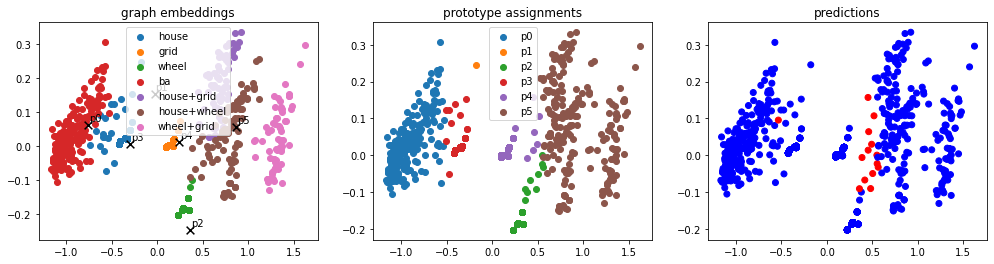

Alpha norms:
tensor([[1.0000, 0.4457, 0.8350, 0.7591, 0.8192, 0.6342],
        [0.0529, 0.0694, 0.1982, 0.0916, 0.1933, 1.0000]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.876539 +- 0.221383
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([262,   1, 158, 105, 159, 227], dtype=int64))
Logic formulas:
For class 0:
0.9734748010610079 (feature000) | (feature004) | (feature002) | ((feature001) | (feature003)
For class 1:
0.9734748010610079 (feature005) | (feature003 & feature004) | (feature004 & feature002) | (feature003 & feature002)
Accuracy as classifier:  0.9735

240: Loss: 0.00987, LEN: 0.009334, AccxC: 0.97, AccO: 0.97, V. Acc: 0.97, V. Loss: 0.01315, V. LEN 0.01
241: Loss: 0.01209, LEN: 0.011603, AccxC: 0.95, AccO: 0.95, V. Acc: 1.00, V. Loss: 0.00746, V. LEN 0.01
242: Loss: 0.01038, LEN: 0.009862, AccxC: 0.97, AccO: 0.97, V. Acc: 0.89, V. Loss: 0.02482, V. LEN 0.02
243: Loss: 0.01319, LEN: 0.012748, AccxC: 0.94, AccO: 0.94, V. Acc: 0.99, V. Loss: 0.00936

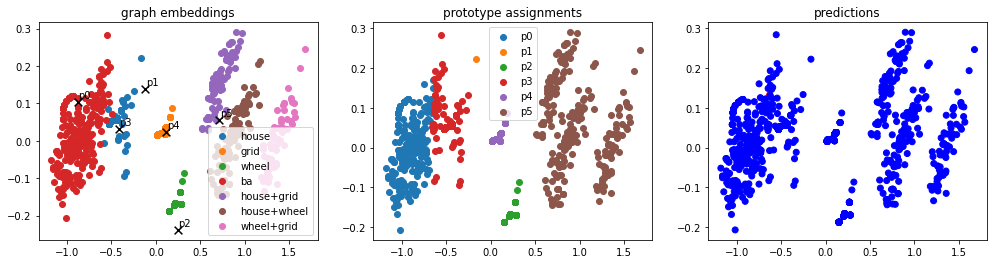

Alpha norms:
tensor([[1.0000, 0.4447, 0.8348, 0.7681, 0.8149, 0.6649],
        [0.0497, 0.0740, 0.1920, 0.0875, 0.1849, 1.0000]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.862917 +- 0.221225
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([217,   1, 151, 150, 153, 240], dtype=int64))
Logic formulas:
For class 0:
0.9907161803713528 (feature000) | (feature004) | (feature002) | (feature003) | ((feature001)
For class 1:
0.9907161803713528 (feature005) | (feature003 & feature004) | (feature004 & feature002) | (feature003 & feature002)
Accuracy as classifier:  0.9907

260: Loss: 0.01024, LEN: 0.009711, AccxC: 0.97, AccO: 0.97, V. Acc: 1.00, V. Loss: 0.00644, V. LEN 0.00
261: Loss: 0.01159, LEN: 0.011188, AccxC: 0.96, AccO: 0.96, V. Acc: 0.96, V. Loss: 0.01461, V. LEN 0.01
262: Loss: 0.01284, LEN: 0.012403, AccxC: 0.96, AccO: 0.96, V. Acc: 0.96, V. Loss: 0.01437, V. LEN 0.01
263: Loss: 0.01062, LEN: 0.010178, AccxC: 0.96, AccO: 0.96, V. Acc: 1.00, V. Loss: 0.00651

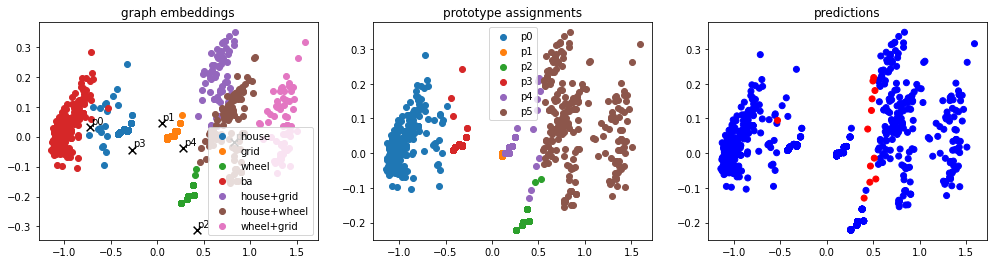

Alpha norms:
tensor([[1.0000, 0.4577, 0.8637, 0.7856, 0.8261, 0.6841],
        [0.0478, 0.0792, 0.1924, 0.0858, 0.1902, 1.0000]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.872369 +- 0.212131
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([268,  56, 151, 100, 107, 230], dtype=int64))
Logic formulas:
For class 0:
0.9761273209549072 (feature000) | (feature004) | (feature002) | (feature003) | ((feature001)
For class 1:
0.9761273209549072 (feature005) | (feature003 & feature004) | (feature001 & feature003) | (feature004 & feature002) | (feature001 & feature002) | (feature003 & feature002) | (feature001 & feature004)
Accuracy as classifier:  0.9761

280: Loss: 0.00950, LEN: 0.009082, AccxC: 0.96, AccO: 0.96, V. Acc: 0.99, V. Loss: 0.00828, V. LEN 0.01
281: Loss: 0.00927, LEN: 0.008861, AccxC: 0.97, AccO: 0.97, V. Acc: 1.00, V. Loss: 0.00621, V. LEN 0.00
282: Loss: 0.01003, LEN: 0.009599, AccxC: 0.97, AccO: 0.97, V. Acc: 0.95, V. Loss: 0.01551, V. LEN 0.01
283: L

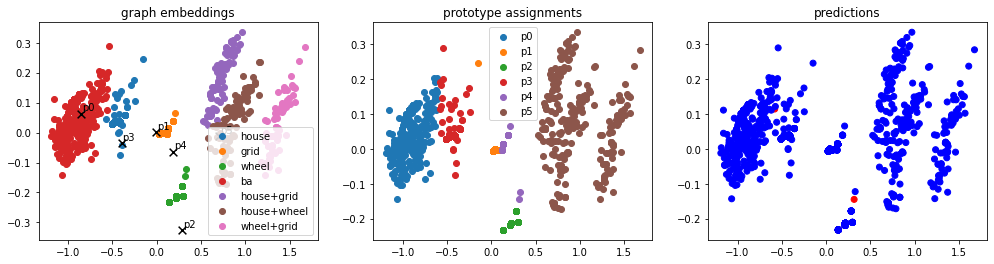

Alpha norms:
tensor([[1.0000, 0.4842, 0.8834, 0.7971, 0.8484, 0.6657],
        [0.0503, 0.0989, 0.2117, 0.0937, 0.2008, 1.0000]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.882574 +- 0.215136
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([243,  97, 149, 124,  59, 240], dtype=int64))
Logic formulas:
For class 0:
0.9893899204244032 (feature000) | (feature004) | (feature002) | (feature003) | ((feature001)
For class 1:
0.9893899204244032 (feature005) | (feature003 & feature001) | (feature004 & feature002) | (feature001 & feature002) | (feature003 & feature004) | (feature003 & feature002) | (feature001 & feature004)
Accuracy as classifier:  0.9894

300: Loss: 0.01043, LEN: 0.009986, AccxC: 0.97, AccO: 0.97, V. Acc: 1.00, V. Loss: 0.00516, V. LEN 0.00
301: Loss: 0.00891, LEN: 0.008453, AccxC: 0.98, AccO: 0.98, V. Acc: 0.94, V. Loss: 0.01731, V. LEN 0.02
302: Loss: 0.01080, LEN: 0.010413, AccxC: 0.96, AccO: 0.96, V. Acc: 1.00, V. Loss: 0.00590, V. LEN 0.00
303: L

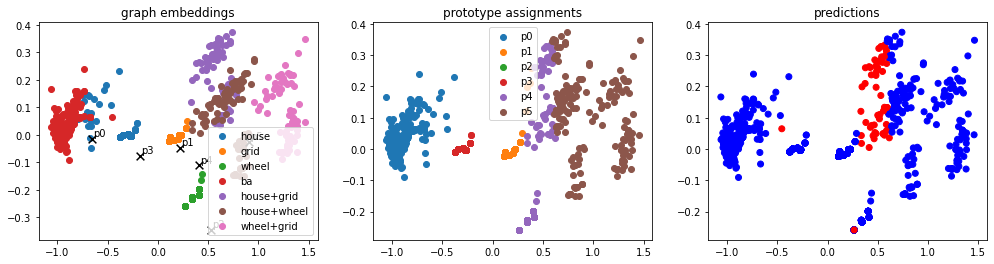

Alpha norms:
tensor([[1.0000, 0.5031, 0.9168, 0.8175, 0.8681, 0.6941],
        [0.0479, 0.0990, 0.2034, 0.0915, 0.2040, 1.0000]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.808780 +- 0.221264
Concept distribution:  (array([0, 1, 3, 4, 5], dtype=int64), array([271, 157,  97, 205, 182], dtype=int64))
Logic formulas:
For class 0:
0.9137931034482759 (feature000) | (feature004) | ((feature001) | (feature003)
For class 1:
0.9137931034482759 (feature005) | (feature003 & feature001) | (feature001 & feature004) | (feature003 & feature004)
Accuracy as classifier:  0.9138

320: Loss: 0.00915, LEN: 0.008784, AccxC: 0.98, AccO: 0.98, V. Acc: 0.94, V. Loss: 0.01666, V. LEN 0.01
321: Loss: 0.00743, LEN: 0.007096, AccxC: 0.97, AccO: 0.97, V. Acc: 1.00, V. Loss: 0.00482, V. LEN 0.00
322: Loss: 0.00927, LEN: 0.008802, AccxC: 0.97, AccO: 0.97, V. Acc: 0.97, V. Loss: 0.01068, V. LEN 0.01
323: Loss: 0.01027, LEN: 0.009882, AccxC: 0.96, AccO: 0.96, V. Acc: 1.00, V. Loss: 0.00546, V. LEN 0.00
324: Loss

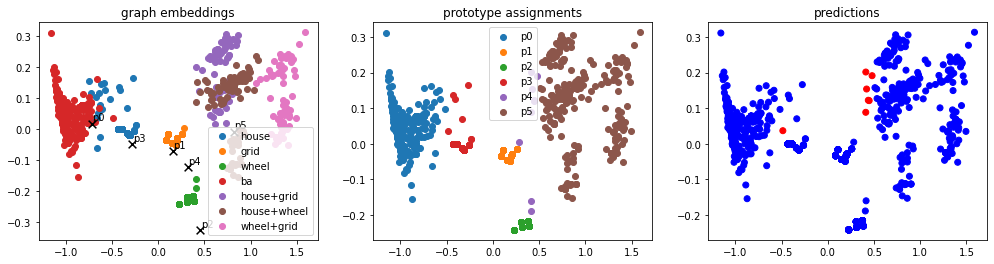

Alpha norms:
tensor([[1.0000, 0.5188, 0.9321, 0.8173, 0.8774, 0.6787],
        [0.0498, 0.1134, 0.2140, 0.0972, 0.2230, 1.0000]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.777515 +- 0.291294
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([266, 152, 149, 102,   9, 234], dtype=int64))
Logic formulas:
For class 0:
0.9827586206896551 (feature000) | (feature002) | (feature003) | ((feature001) | (feature004)
For class 1:
0.9827586206896551 (feature005) | (feature003 & feature001) | (feature001 & feature002) | (feature003 & feature002) | (feature001 & feature004)
Accuracy as classifier:  0.9828

340: Loss: 0.00795, LEN: 0.007632, AccxC: 0.97, AccO: 0.97, V. Acc: 1.00, V. Loss: 0.00439, V. LEN 0.00
341: Loss: 0.00702, LEN: 0.006739, AccxC: 0.98, AccO: 0.98, V. Acc: 0.93, V. Loss: 0.01694, V. LEN 0.02
342: Loss: 0.00696, LEN: 0.006631, AccxC: 0.98, AccO: 0.98, V. Acc: 0.98, V. Loss: 0.00723, V. LEN 0.01
343: Loss: 0.00710, LEN: 0.006789, AccxC: 0.98, AccO: 0.98, V.

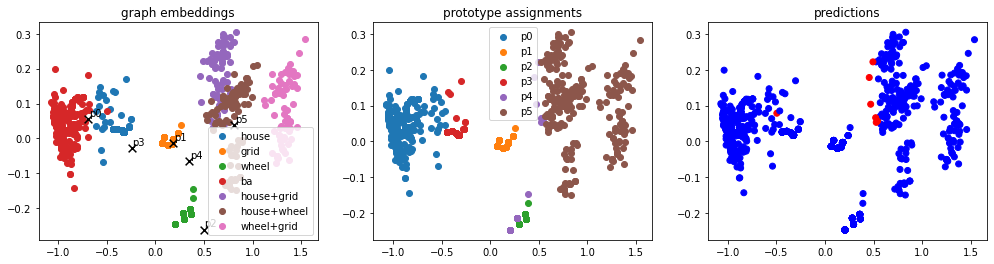

Alpha norms:
tensor([[1.0000, 0.5152, 0.9313, 0.7965, 0.8608, 0.6804],
        [0.0493, 0.1115, 0.2061, 0.0946, 0.2152, 1.0000]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.875625 +- 0.212976
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([267, 153,  92, 101,  65, 234], dtype=int64))
Logic formulas:
For class 0:
0.9827586206896551 (feature000) | (feature002) | (feature003) | ((feature001) | (feature004)
For class 1:
0.9827586206896551 (feature005) | (feature003 & feature001) | (feature001 & feature002) | (feature001 & feature004) | (feature003 & feature002) | (feature003 & feature004)
Accuracy as classifier:  0.9828

360: Loss: 0.00625, LEN: 0.005879, AccxC: 0.98, AccO: 0.98, V. Acc: 1.00, V. Loss: 0.00524, V. LEN 0.00
361: Loss: 0.00641, LEN: 0.006099, AccxC: 0.98, AccO: 0.98, V. Acc: 0.90, V. Loss: 0.02051, V. LEN 0.02
362: Loss: 0.00790, LEN: 0.007570, AccxC: 0.97, AccO: 0.97, V. Acc: 1.00, V. Loss: 0.00433, V. LEN 0.00
363: Loss: 0.00780, LEN: 0.007452,

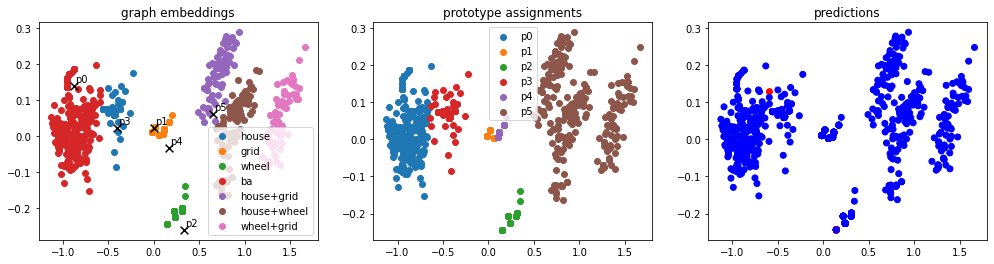

Alpha norms:
tensor([[1.0000, 0.5191, 0.9360, 0.7930, 0.8496, 0.6503],
        [0.0545, 0.1227, 0.2172, 0.0999, 0.2203, 1.0000]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.891286 +- 0.218819
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([244,  96, 151, 124,  57, 240], dtype=int64))
Logic formulas:
For class 0:
0.9907161803713528 (feature000) | (feature004) | (feature002) | (feature003) | ((feature001)
For class 1:
0.9907161803713528 (feature005) | (feature003 & feature001) | (feature002 & feature004) | (feature001 & feature002) | (feature003 & feature004) | (feature003 & feature002)
Accuracy as classifier:  0.9907

380: Loss: 0.00938, LEN: 0.008929, AccxC: 0.98, AccO: 0.98, V. Acc: 1.00, V. Loss: 0.00390, V. LEN 0.00
381: Loss: 0.00698, LEN: 0.006657, AccxC: 0.98, AccO: 0.98, V. Acc: 0.91, V. Loss: 0.02146, V. LEN 0.02
382: Loss: 0.00588, LEN: 0.005605, AccxC: 0.98, AccO: 0.98, V. Acc: 0.97, V. Loss: 0.01089, V. LEN 0.01
383: Loss: 0.00568, LEN: 0.005359,

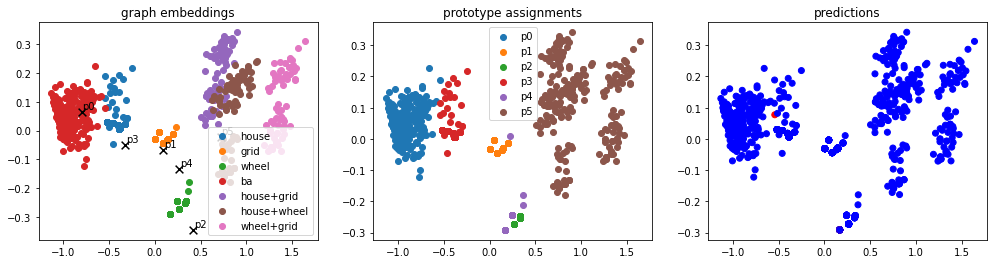

Alpha norms:
tensor([[1.0000, 0.5257, 0.9481, 0.7896, 0.8381, 0.6479],
        [0.0560, 0.1255, 0.2242, 0.1039, 0.2373, 1.0000]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.895874 +- 0.219970
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([251, 152,  91, 117,  61, 240], dtype=int64))
Logic formulas:
For class 0:
0.9907161803713528 (feature000) | (feature002) | (feature003) | ((feature001) | (feature004)
For class 1:
0.9907161803713528 (feature005) | (feature003 & feature001) | (feature001 & feature002) | (feature001 & feature004) | (feature003 & feature002) | (feature003 & feature004)
Accuracy as classifier:  0.9907

400: Loss: 0.00779, LEN: 0.007453, AccxC: 0.98, AccO: 0.98, V. Acc: 1.00, V. Loss: 0.00512, V. LEN 0.00
401: Loss: 0.00680, LEN: 0.006499, AccxC: 0.98, AccO: 0.98, V. Acc: 0.91, V. Loss: 0.02254, V. LEN 0.02
402: Loss: 0.00933, LEN: 0.009018, AccxC: 0.96, AccO: 0.96, V. Acc: 0.99, V. Loss: 0.00707, V. LEN 0.01
403: Loss: 0.00740, LEN: 0.007062,

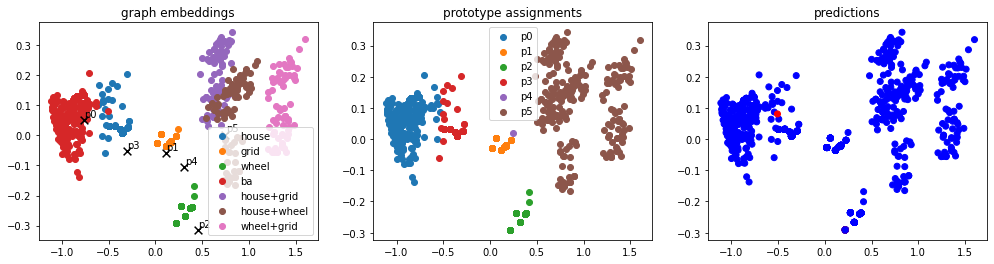

Alpha norms:
tensor([[1.0000, 0.5343, 0.9758, 0.7840, 0.8542, 0.6741],
        [0.0546, 0.1232, 0.2231, 0.0990, 0.2210, 1.0000]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.894011 +- 0.219340
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([258, 152, 151, 110,   1, 240], dtype=int64))
Logic formulas:
For class 0:
0.9907161803713528 (feature000) | (feature002) | (feature003) | ((feature001) | (feature004)
For class 1:
0.9907161803713528 (feature005) | (feature003 & feature001) | (feature001 & feature002) | (feature003 & feature002)
Accuracy as classifier:  0.9907

420: Loss: 0.00745, LEN: 0.007180, AccxC: 0.98, AccO: 0.98, V. Acc: 1.00, V. Loss: 0.00383, V. LEN 0.00
421: Loss: 0.00523, LEN: 0.004928, AccxC: 0.99, AccO: 0.99, V. Acc: 0.95, V. Loss: 0.01374, V. LEN 0.01
422: Loss: 0.00630, LEN: 0.006017, AccxC: 0.98, AccO: 0.98, V. Acc: 0.98, V. Loss: 0.00784, V. LEN 0.01
423: Loss: 0.00737, LEN: 0.007056, AccxC: 0.98, AccO: 0.98, V. Acc: 1.00, V. Loss: 0.00395

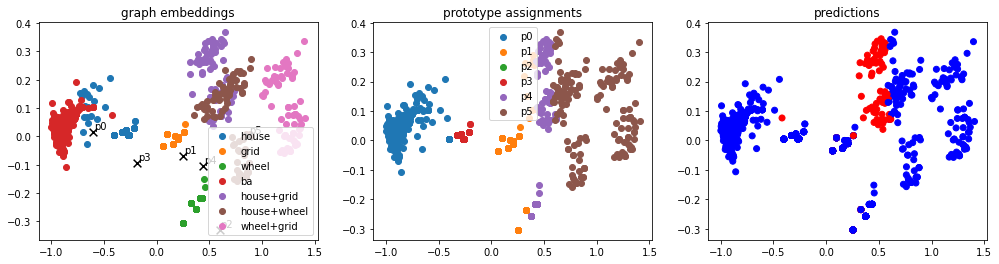

Alpha norms:
tensor([[1.0000, 0.5395, 0.9796, 0.7780, 0.8621, 0.6832],
        [0.0531, 0.1247, 0.2220, 0.0954, 0.2153, 1.0000]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.719311 +- 0.185330
Concept distribution:  (array([0, 1, 3, 4, 5], dtype=int64), array([298, 222,  70, 157, 165], dtype=int64))
Logic formulas:
For class 0:
0.8660477453580901 (feature000) | (feature004) | ((feature001) | (feature003)
For class 1:
0.8660477453580901 (feature005) | (feature003 & feature001) | (feature001 & feature004) | ((feature000 & feature001) | ((feature000 & feature004) | (feature003 & feature004)
Accuracy as classifier:  0.866

440: Loss: 0.00696, LEN: 0.006543, AccxC: 0.98, AccO: 0.98, V. Acc: 0.93, V. Loss: 0.02033, V. LEN 0.02
441: Loss: 0.00781, LEN: 0.007374, AccxC: 0.98, AccO: 0.98, V. Acc: 1.00, V. Loss: 0.00342, V. LEN 0.00
442: Loss: 0.00878, LEN: 0.008472, AccxC: 0.98, AccO: 0.98, V. Acc: 0.86, V. Loss: 0.04239, V. LEN 0.04
443: Loss: 0.00769, LEN: 0.007317, AccxC: 0.97, AccO: 0.

In [8]:
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging_train))
train_group_loader = DataLoader(dataset_train, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_val))
val_group_loader = DataLoader(dataset_val, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_test))
test_group_loader = DataLoader(dataset_test, batch_sampler=batch_sampler)


torch.manual_seed(42)
hyper = {
    "len_lr": 0.0005,
    "proto_lr": 0.001,
    "le_emb_lr": 0.001,
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 2, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": True,
    "debug_prototypes": False,
    "num_prototypes": 6,
    "dim_prototypes": 10,
    "num_le_features": 5,
    "activation": "leaky",
    "assign_func": "straight_sim",
    "LEN_temperature": 1,
    "remove_attention": True,
    "log_images": True,
    "log_models": False,
    "num_epochs": 2000
}

len_model    = models.LEN(hyper["num_prototypes"], 
                          hyper["LEN_temperature"], 
                          remove_attention=hyper["remove_attention"]).to(device)
le_model     = models.LEEmbedder(num_features=hyper["num_le_features"], 
                                 activation=hyper["activation"], 
                                 num_hidden=hyper["dim_prototypes"]).to(device)
expl         = models.GlobalExplainer(len_model, 
                               le_model, 
                               train_group_loader, 
                               val_group_loader, 
                               device, 
                               hyper_params=hyper,
                               classes_names=bamultishapes2_classes_names,
                               dataset_name=DATASET_NAME).to(device)

prefix = "DEBUG" if hyper["debug_prototypes"] else ""
suffix = "no attn" if hyper["remove_attention"] else ""
expl.iterate(num_epochs=hyper["num_epochs"], log_wandb=False, name_wandb=f"MShapes2 {hyper['num_prototypes']}prots {prefix} {suffix}")

(array([0., 1., 2., 3., 4., 5., 6.], dtype=float32), array([17, 20, 18, 33,  9, 11, 11], dtype=int64))
[0.9627799  0.02182852]


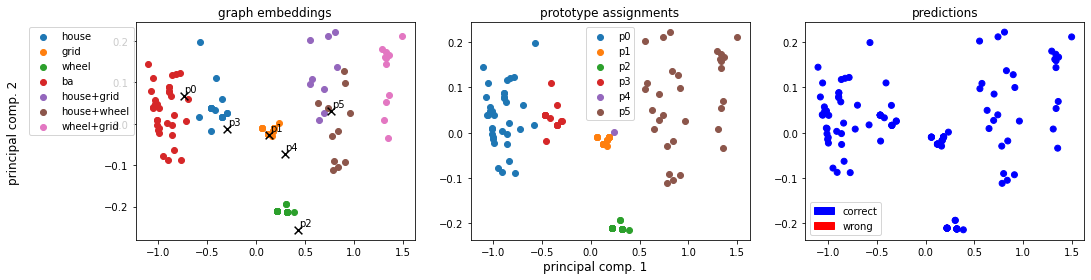

Alpha norms:
tensor([[1.0000, 0.5151, 0.9292, 0.8029, 0.8643, 0.6816],
        [0.0489, 0.1109, 0.2053, 0.0948, 0.2167, 1.0000]],
       grad_fn=<DivBackward0>)
Concept Purity: 0.882949 +- 0.237098
Concept distribution:  (array([0, 1, 2, 3, 4, 5], dtype=int64), array([35, 19, 18, 15,  1, 31], dtype=int64))
Logic formulas:
For class 0:
0.98989898989899 (feature000) | (feature002) | (feature003) | ((feature001)
For class 1:
0.98989898989899 (feature005) | (feature003 & feature001) | (feature001 & feature002) | (feature002 & feature004) | (feature003 & feature002)
Accuracy as classifier:  0.9899



In [22]:
expl.inspect_embedding(test_group_loader)

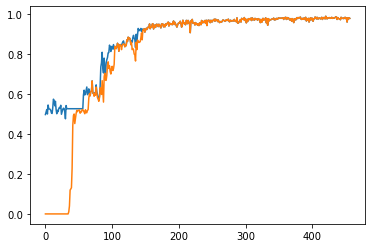

In [9]:
plt.plot([e["acc_per_class"] for e in expl.train_metrics])
plt.plot([e["acc_overall"] for e in expl.train_metrics])

# MUTAG

In [36]:
DATASET_NAME = "Mutag"

In [37]:
adjs_train , \
edge_weights_train , \
ori_adjs_train , \
ori_classes_train , \
belonging_train , \
summary_predictions_train , \
le_classes_train ,\
embeddings_train = read_mutagenicity(evaluate_method=False, 
                                     manual_cut=0.37731856,
                                     split="TRAIN")

print(np.unique(le_classes_train, return_counts=True))

belonging_train2 = np.array(belonging_train)
le_classes_train = np.array(le_classes_train)
c = 0
for b in np.unique(belonging_train):
    if ori_classes_train[b] == 1 and 0 in le_classes_train[belonging_train2 == b]:
        c += 1
print("Samples of class 1 containing NO2: ", c/len(ori_classes_train))
c = 0
for b in np.unique(belonging_train):
    if ori_classes_train[b] == 0 and 0 not in le_classes_train[belonging_train2 == b]:
        c += 1
print("Samples of class 0 not containing NO2: ", c/len(ori_classes_train))

print(len(adjs_train) , len(edge_weights_train), len(ori_adjs_train) , len(ori_classes_train) , len(belonging_train))
np.unique(summary_predictions_train["wrong"], return_counts=True) , np.unique(summary_predictions_train["correct"], return_counts=True)

This is a NH2 local explanation
(array([0, 1]), array([619, 400], dtype=int64))
Samples of class 1 containing NO2:  0.04709141274238227
Samples of class 0 not containing NO2:  0.12188365650969529
1019 1019 722 722 1019


((array([0, 1]), array([ 88, 346], dtype=int64)),
 (array([0, 1]), array([1833, 1202], dtype=int64)))

In [38]:
adjs_val , \
edge_weights_val , \
ori_adjs_val , \
ori_classes_val , \
belonging_val , \
summary_predictions_val , \
le_classes_val ,\
embeddings_val = read_mutagenicity(evaluate_method=False, 
                                   manual_cut=0.37731856,
                                   split="VAL")

print(np.unique(le_classes_val, return_counts=True))

belonging_val2 = np.array(belonging_val)
le_classes_val = np.array(le_classes_val)
c = 0
for b in np.unique(belonging_val):
    if ori_classes_val[b] == 1 and 0 in le_classes_val[belonging_val2 == b]:
        c += 1
print("Samples of class 1 containing NO2: ", c/len(ori_classes_val))
c = 0
for b in np.unique(belonging_val):
    if ori_classes_val[b] == 0 and 0 not in le_classes_val[belonging_val2 == b]:
        c += 1
print("Samples of class 0 not containing NO2: ", c/len(ori_classes_val))

print(len(adjs_val) , len(edge_weights_val), len(ori_adjs_val) , len(ori_classes_val) , len(belonging_val))
np.unique(summary_predictions_val["wrong"], return_counts=True) , np.unique(summary_predictions_val["correct"], return_counts=True)

(array([0, 1]), array([88, 50], dtype=int64))
Samples of class 1 containing NO2:  0.02127659574468085
Samples of class 0 not containing NO2:  0.11702127659574468
138 138 94 94 138


((array([0, 1]), array([ 8, 49], dtype=int64)),
 (array([0, 1]), array([237, 140], dtype=int64)))

In [39]:
adjs_test , \
edge_weights_test , \
ori_adjs_test , \
ori_classes_test , \
belonging_test , \
summary_predictions_test , \
le_classes_test ,\
embeddings_test = read_mutagenicity(evaluate_method=False, 
                                   manual_cut=0.37731856,
                                   split="TEST")

print(np.unique(le_classes_test, return_counts=True))

belonging_test2 = np.array(belonging_test)
le_classes_test = np.array(le_classes_test)
c = 0
for b in np.unique(belonging_test):
    if ori_classes_test[b] == 1 and 0 in le_classes_test[belonging_test2 == b]:
        c += 1
print("Samples of class 1 containing NO2: ", c/len(ori_classes_test))
c = 0
for b in np.unique(belonging_test):
    if ori_classes_test[b] == 0 and 0 not in le_classes_test[belonging_test2 == b]:
        c += 1
print("Samples of class 0 not containing NO2: ", c/len(ori_classes_test))

print(len(adjs_test) , len(edge_weights_test), len(ori_adjs_test) , len(ori_classes_test) , len(belonging_test))
np.unique(summary_predictions_test["wrong"], return_counts=True) , np.unique(summary_predictions_test["correct"], return_counts=True)

(array([0, 1]), array([65, 54], dtype=int64))
Samples of class 1 containing NO2:  0.011904761904761904
Samples of class 0 not containing NO2:  0.14285714285714285
119 119 84 84 119


((array([0, 1]), array([ 6, 54], dtype=int64)),
 (array([0, 1]), array([229, 145], dtype=int64)))

C:\Users\Steve\Desktop\GNN\gnn_logic_global_expl\code\utils.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  num_nodes=adj.shape[0],


(array([0, 1]), array([619, 400], dtype=int64))
(tensor([0, 1]), tensor([748, 271]))


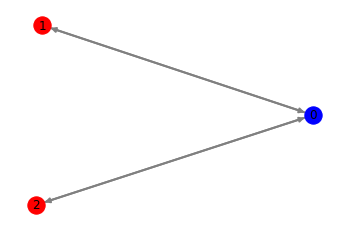

(15, tensor([15]))

In [34]:
device = "cpu" #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = None  

dataset_train = utils.LocalExplanationsDataset("", adjs_train, edge_weights_test, "embeddings", transform=transform, y=le_classes_train, belonging=belonging_train, task_y=ori_classes_train, precomputed_embeddings=embeddings_train)
dataset_val = utils.LocalExplanationsDataset("", adjs_val, edge_weights_val, "embeddings", transform=transform, y=le_classes_val, belonging=belonging_val, task_y=ori_classes_val, precomputed_embeddings=embeddings_val)
dataset_test = utils.LocalExplanationsDataset("", adjs_test, edge_weights_test, "embeddings", transform=transform, y=le_classes_test, belonging=belonging_test, task_y=ori_classes_test, precomputed_embeddings=embeddings_test)


##
# debug Dataset
##
print(np.unique(le_classes_train, return_counts=True))
print(torch.unique(dataset_train.data.task_y, return_counts=True))
idx = 18
utils.plot_molecule(dataset_train[idx])
belonging_train[idx] , dataset_train[idx].graph_id

(array([0., 1.], dtype=float32), array([619, 400], dtype=int64))
[0.9011763  0.05715322]


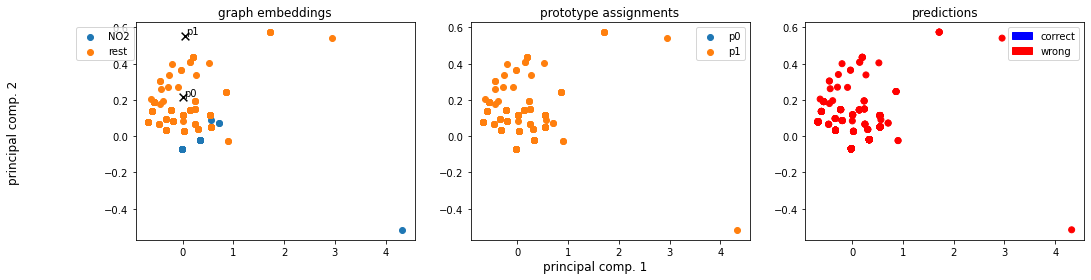

Alpha norms:
tensor([[1.0000, 0.6722],
        [0.7495, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.607458 +- 0.000000
Concept distribution:  (array([1], dtype=int64), array([1019], dtype=int64))
Logic formulas:
For class 0:
0.0 ()
For class 1:
0.0 ()
Accuracy as classifier:  0.0

  1: Loss: 0.21636, LEN: 0.065177, AccxC: 0.26, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.27739, V. LEN 0.09
  2: Loss: 0.17933, LEN: 0.064963, AccxC: 0.74, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.23074, V. LEN 0.09
  3: Loss: 0.14539, LEN: 0.064781, AccxC: 0.74, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.18294, V. LEN 0.09
  4: Loss: 0.11528, LEN: 0.064590, AccxC: 0.74, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.15542, V. LEN 0.09
  5: Loss: 0.10488, LEN: 0.064419, AccxC: 0.74, AccO: 0.00, V. Acc: 0.00, V. Loss: 0.14353, V. LEN 0.09
  6: Loss: 0.09618, LEN: 0.064217, AccxC: 0.74, AccO: 0.08, V. Acc: 0.76, V. Loss: 0.12383, V. LEN 0.09
  7: Loss: 0.08617, LEN: 0.064023, AccxC: 0.74, AccO: 0.70, V. Acc: 0.74, V. Loss: 0.1

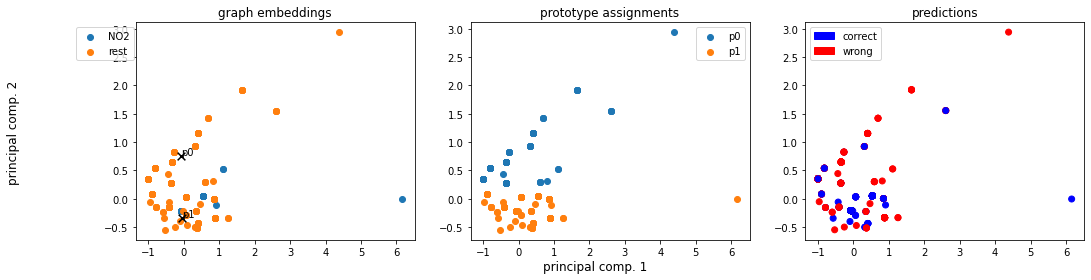

Alpha norms:
tensor([[1.0000, 0.9340],
        [0.7505, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.884095 +- 0.107017
Concept distribution:  (array([0, 1], dtype=int64), array([225, 794], dtype=int64))
Logic formulas:
For class 0:
0.7991689750692521 ((feature001) | ((feature001 & feature000)
For class 1:
0.0 ()
Accuracy as classifier:  0.0

 20: Loss: 0.06260, LEN: 0.060448, AccxC: 0.80, AccO: 0.68, V. Acc: 0.70, V. Loss: 0.08299, V. LEN 0.08
 21: Loss: 0.06140, LEN: 0.060100, AccxC: 0.79, AccO: 0.68, V. Acc: 0.70, V. Loss: 0.08209, V. LEN 0.08
 22: Loss: 0.06102, LEN: 0.059904, AccxC: 0.79, AccO: 0.67, V. Acc: 0.70, V. Loss: 0.08108, V. LEN 0.08
 23: Loss: 0.06072, LEN: 0.059289, AccxC: 0.80, AccO: 0.69, V. Acc: 0.70, V. Loss: 0.08031, V. LEN 0.08
 24: Loss: 0.05997, LEN: 0.058909, AccxC: 0.80, AccO: 0.68, V. Acc: 0.70, V. Loss: 0.07953, V. LEN 0.08
 25: Loss: 0.06010, LEN: 0.058517, AccxC: 0.80, AccO: 0.69, V. Acc: 0.70, V. Loss: 0.07960, V. LEN 0.08
 26: Loss: 0.05914, LEN:

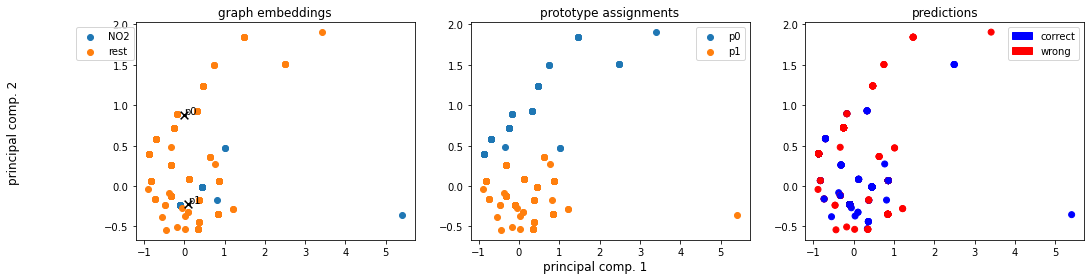

Alpha norms:
tensor([[0.7263, 1.0000],
        [0.8811, 1.0000]], grad_fn=<DivBackward0>)
Concept Purity: 0.876080 +- 0.114351
Concept distribution:  (array([0, 1], dtype=int64), array([209, 810], dtype=int64))
Logic formulas:
For class 0:
0.8019390581717452 (feature001) | ((feature000 & feature001)
For class 1:
0.0 ()
Accuracy as classifier:  0.0

 40: Loss: 0.05422, LEN: 0.053482, AccxC: 0.80, AccO: 0.69, V. Acc: 0.70, V. Loss: 0.07154, V. LEN 0.07
 41: Loss: 0.05439, LEN: 0.053387, AccxC: 0.80, AccO: 0.69, V. Acc: 0.70, V. Loss: 0.07218, V. LEN 0.07
 42: Loss: 0.05411, LEN: 0.053062, AccxC: 0.80, AccO: 0.69, V. Acc: 0.70, V. Loss: 0.07175, V. LEN 0.07
 43: Loss: 0.05342, LEN: 0.052651, AccxC: 0.80, AccO: 0.69, V. Acc: 0.70, V. Loss: 0.07117, V. LEN 0.07
 44: Loss: 0.05347, LEN: 0.052384, AccxC: 0.80, AccO: 0.69, V. Acc: 0.70, V. Loss: 0.06978, V. LEN 0.07
 45: Loss: 0.05320, LEN: 0.052315, AccxC: 0.79, AccO: 0.68, V. Acc: 0.70, V. Loss: 0.06899, V. LEN 0.07
 46: Loss: 0.05216, LEN: 

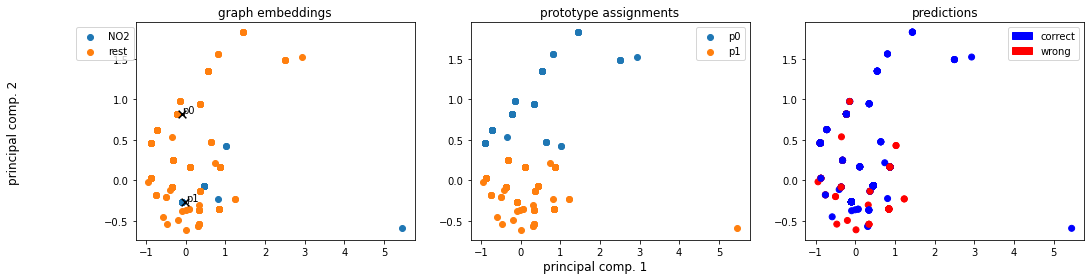

Alpha norms:
tensor([[0.6075, 1.0000],
        [1.0000, 0.8279]], grad_fn=<DivBackward0>)
Concept Purity: 0.878060 +- 0.112551
Concept distribution:  (array([0, 1], dtype=int64), array([213, 806], dtype=int64))
Logic formulas:
For class 0:
0.8074792243767313 (feature001) | ((feature000 & feature001)
For class 1:
0.8074792243767313 (feature000)
Accuracy as classifier:  0.8075

 60: Loss: 0.04982, LEN: 0.048673, AccxC: 0.80, AccO: 0.80, V. Acc: 0.86, V. Loss: 0.06055, V. LEN 0.06
 61: Loss: 0.04962, LEN: 0.048650, AccxC: 0.80, AccO: 0.80, V. Acc: 0.86, V. Loss: 0.06087, V. LEN 0.06
 62: Loss: 0.04900, LEN: 0.047917, AccxC: 0.81, AccO: 0.81, V. Acc: 0.86, V. Loss: 0.06049, V. LEN 0.06
 63: Loss: 0.04936, LEN: 0.048365, AccxC: 0.80, AccO: 0.80, V. Acc: 0.86, V. Loss: 0.06045, V. LEN 0.06
 64: Loss: 0.04878, LEN: 0.047851, AccxC: 0.80, AccO: 0.80, V. Acc: 0.86, V. Loss: 0.06079, V. LEN 0.06
 65: Loss: 0.04847, LEN: 0.047733, AccxC: 0.81, AccO: 0.81, V. Acc: 0.86, V. Loss: 0.06144, V. LEN 0.

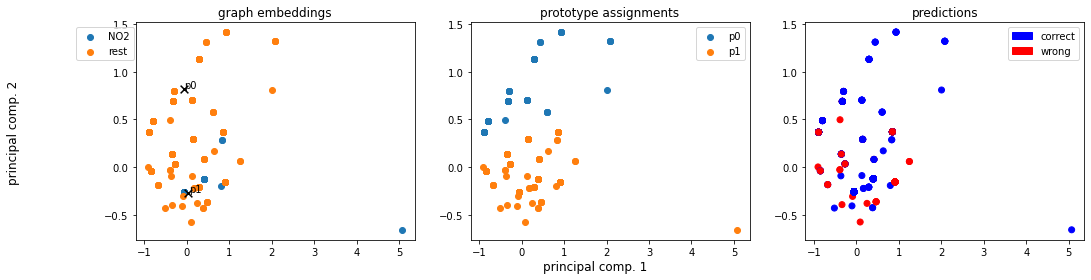

Alpha norms:
tensor([[0.5795, 1.0000],
        [1.0000, 0.6974]], grad_fn=<DivBackward0>)
Concept Purity: 0.883045 +- 0.116955
Concept distribution:  (array([0, 1], dtype=int64), array([211, 808], dtype=int64))
Logic formulas:
For class 0:
0.8102493074792244 (feature001) | ((feature000 & feature001)
For class 1:
0.8102493074792244 (feature000)
Accuracy as classifier:  0.8102

 80: Loss: 0.04633, LEN: 0.045588, AccxC: 0.82, AccO: 0.82, V. Acc: 0.86, V. Loss: 0.05775, V. LEN 0.05
 81: Loss: 0.04645, LEN: 0.045553, AccxC: 0.81, AccO: 0.81, V. Acc: 0.86, V. Loss: 0.05808, V. LEN 0.05
 82: Loss: 0.04629, LEN: 0.045328, AccxC: 0.81, AccO: 0.81, V. Acc: 0.86, V. Loss: 0.05619, V. LEN 0.05
 83: Loss: 0.04646, LEN: 0.045533, AccxC: 0.81, AccO: 0.81, V. Acc: 0.86, V. Loss: 0.05604, V. LEN 0.05
 84: Loss: 0.04591, LEN: 0.045139, AccxC: 0.81, AccO: 0.81, V. Acc: 0.86, V. Loss: 0.05576, V. LEN 0.05
 85: Loss: 0.04657, LEN: 0.045846, AccxC: 0.81, AccO: 0.81, V. Acc: 0.86, V. Loss: 0.05613, V. LEN 0.

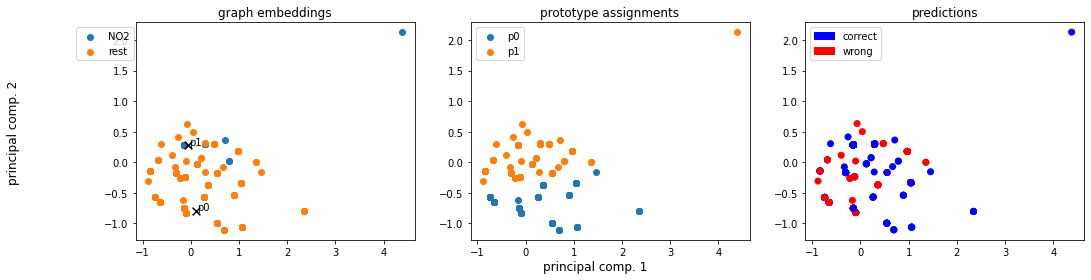

Alpha norms:
tensor([[0.6052, 1.0000],
        [1.0000, 0.6138]], grad_fn=<DivBackward0>)
Concept Purity: 0.940256 +- 0.059744
Concept distribution:  (array([0, 1], dtype=int64), array([316, 703], dtype=int64))
Logic formulas:
For class 0:
0.8047091412742382 (feature001) | ((feature000 & feature001)
For class 1:
0.8047091412742382 (feature000)
Accuracy as classifier:  0.8047

100: Loss: 0.04446, LEN: 0.043853, AccxC: 0.81, AccO: 0.81, V. Acc: 0.86, V. Loss: 0.05430, V. LEN 0.05
101: Loss: 0.04498, LEN: 0.043815, AccxC: 0.81, AccO: 0.81, V. Acc: 0.86, V. Loss: 0.05443, V. LEN 0.05
102: Loss: 0.04533, LEN: 0.044407, AccxC: 0.81, AccO: 0.81, V. Acc: 0.86, V. Loss: 0.05359, V. LEN 0.05
103: Loss: 0.04445, LEN: 0.043652, AccxC: 0.81, AccO: 0.81, V. Acc: 0.86, V. Loss: 0.05367, V. LEN 0.05
104: Loss: 0.04502, LEN: 0.044288, AccxC: 0.80, AccO: 0.80, V. Acc: 0.86, V. Loss: 0.05418, V. LEN 0.05
105: Loss: 0.04544, LEN: 0.044706, AccxC: 0.80, AccO: 0.80, V. Acc: 0.86, V. Loss: 0.05418, V. LEN 0.

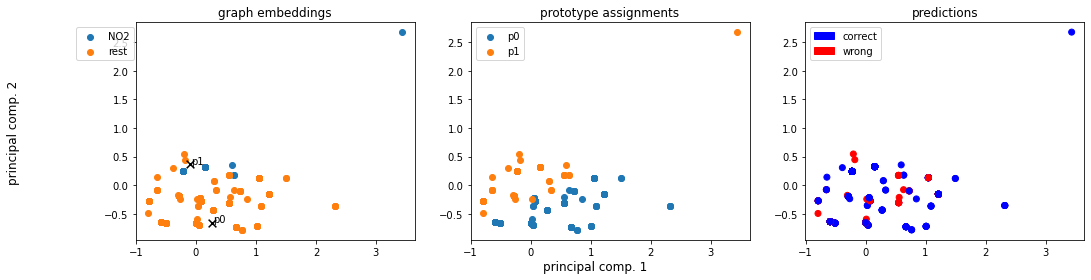

Alpha norms:
tensor([[0.6457, 1.0000],
        [1.0000, 0.5968]], grad_fn=<DivBackward0>)
Concept Purity: 0.970365 +- 0.029635
Concept distribution:  (array([0, 1], dtype=int64), array([361, 658], dtype=int64))
Logic formulas:
For class 0:
0.8282548476454293 (feature001) | ((feature000 & feature001)
For class 1:
0.8282548476454293 (feature000)
Accuracy as classifier:  0.8283

120: Loss: 0.04236, LEN: 0.041739, AccxC: 0.81, AccO: 0.81, V. Acc: 0.88, V. Loss: 0.05019, V. LEN 0.05
121: Loss: 0.04277, LEN: 0.042172, AccxC: 0.81, AccO: 0.81, V. Acc: 0.88, V. Loss: 0.04960, V. LEN 0.05
122: Loss: 0.04216, LEN: 0.041572, AccxC: 0.81, AccO: 0.81, V. Acc: 0.88, V. Loss: 0.04930, V. LEN 0.05
123: Loss: 0.04169, LEN: 0.040932, AccxC: 0.82, AccO: 0.82, V. Acc: 0.88, V. Loss: 0.04863, V. LEN 0.05
124: Loss: 0.04083, LEN: 0.040172, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04844, V. LEN 0.05
125: Loss: 0.04236, LEN: 0.041818, AccxC: 0.81, AccO: 0.81, V. Acc: 0.88, V. Loss: 0.04899, V. LEN 0.

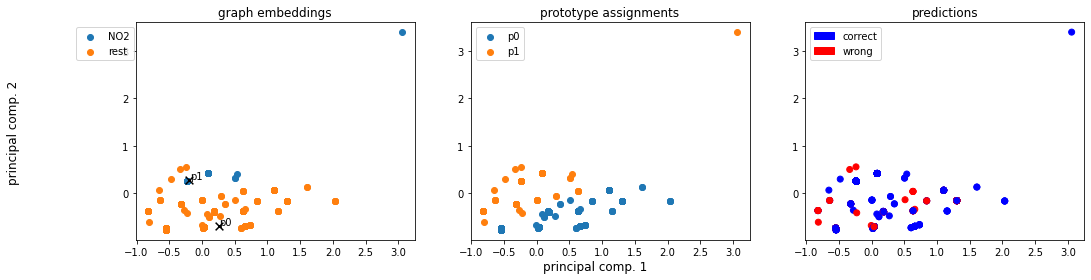

Alpha norms:
tensor([[0.6654, 1.0000],
        [1.0000, 0.5625]], grad_fn=<DivBackward0>)
Concept Purity: 0.968939 +- 0.031061
Concept distribution:  (array([0, 1], dtype=int64), array([359, 660], dtype=int64))
Logic formulas:
For class 0:
0.8296398891966759 (feature001) | ((feature000 & feature001)
For class 1:
0.8296398891966759 (feature000)
Accuracy as classifier:  0.8296

140: Loss: 0.04029, LEN: 0.039601, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04688, V. LEN 0.04
141: Loss: 0.04036, LEN: 0.039642, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04741, V. LEN 0.04
142: Loss: 0.04029, LEN: 0.039731, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04791, V. LEN 0.04
143: Loss: 0.03941, LEN: 0.038841, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04820, V. LEN 0.04
144: Loss: 0.04058, LEN: 0.039869, AccxC: 0.82, AccO: 0.82, V. Acc: 0.88, V. Loss: 0.04714, V. LEN 0.04
145: Loss: 0.03964, LEN: 0.039071, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04714, V. LEN 0.

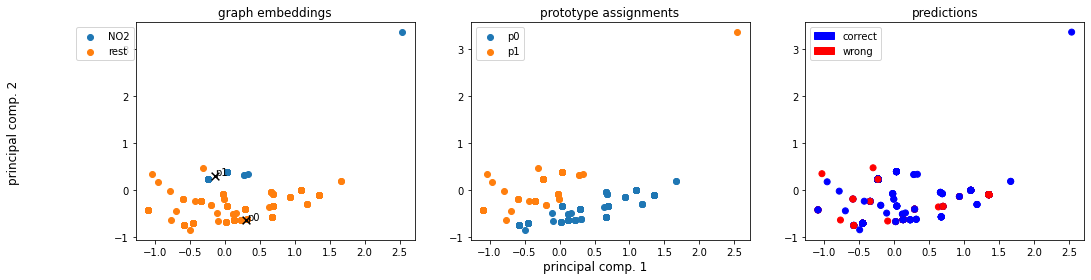

Alpha norms:
tensor([[0.7113, 1.0000],
        [1.0000, 0.5300]], grad_fn=<DivBackward0>)
Concept Purity: 0.970365 +- 0.029635
Concept distribution:  (array([0, 1], dtype=int64), array([361, 658], dtype=int64))
Logic formulas:
For class 0:
0.8379501385041551 (feature001) | ((feature000 & feature001)
For class 1:
0.8379501385041551 (feature000)
Accuracy as classifier:  0.838

160: Loss: 0.03825, LEN: 0.037452, AccxC: 0.84, AccO: 0.84, V. Acc: 0.88, V. Loss: 0.04623, V. LEN 0.04
161: Loss: 0.03809, LEN: 0.037394, AccxC: 0.84, AccO: 0.84, V. Acc: 0.88, V. Loss: 0.04544, V. LEN 0.04
162: Loss: 0.03837, LEN: 0.037709, AccxC: 0.84, AccO: 0.84, V. Acc: 0.88, V. Loss: 0.04595, V. LEN 0.04
163: Loss: 0.03841, LEN: 0.037810, AccxC: 0.84, AccO: 0.84, V. Acc: 0.88, V. Loss: 0.04668, V. LEN 0.04
164: Loss: 0.03787, LEN: 0.037383, AccxC: 0.84, AccO: 0.84, V. Acc: 0.88, V. Loss: 0.04765, V. LEN 0.04
165: Loss: 0.03876, LEN: 0.038278, AccxC: 0.84, AccO: 0.84, V. Acc: 0.88, V. Loss: 0.04793, V. LEN 0.0

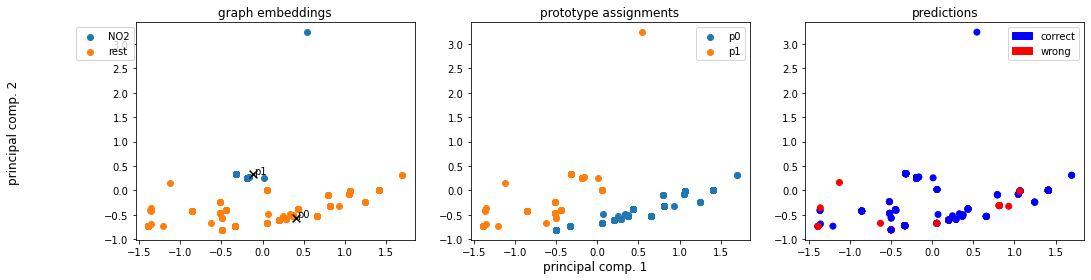

Alpha norms:
tensor([[0.7557, 1.0000],
        [1.0000, 0.4969]], grad_fn=<DivBackward0>)
Concept Purity: 0.963323 +- 0.036677
Concept distribution:  (array([0, 1], dtype=int64), array([351, 668], dtype=int64))
Logic formulas:
For class 0:
0.8365650969529086 (feature001) | ((feature000 & feature001)
For class 1:
0.8365650969529086 (feature000)
Accuracy as classifier:  0.8366

180: Loss: 0.03865, LEN: 0.038021, AccxC: 0.84, AccO: 0.84, V. Acc: 0.88, V. Loss: 0.04774, V. LEN 0.05
181: Loss: 0.03765, LEN: 0.037069, AccxC: 0.84, AccO: 0.84, V. Acc: 0.88, V. Loss: 0.04810, V. LEN 0.05
182: Loss: 0.03818, LEN: 0.037689, AccxC: 0.84, AccO: 0.84, V. Acc: 0.88, V. Loss: 0.04669, V. LEN 0.04
183: Loss: 0.03772, LEN: 0.037199, AccxC: 0.84, AccO: 0.84, V. Acc: 0.88, V. Loss: 0.04707, V. LEN 0.04
184: Loss: 0.03805, LEN: 0.037395, AccxC: 0.84, AccO: 0.84, V. Acc: 0.88, V. Loss: 0.04636, V. LEN 0.04
185: Loss: 0.03834, LEN: 0.037618, AccxC: 0.84, AccO: 0.84, V. Acc: 0.88, V. Loss: 0.04608, V. LEN 0.

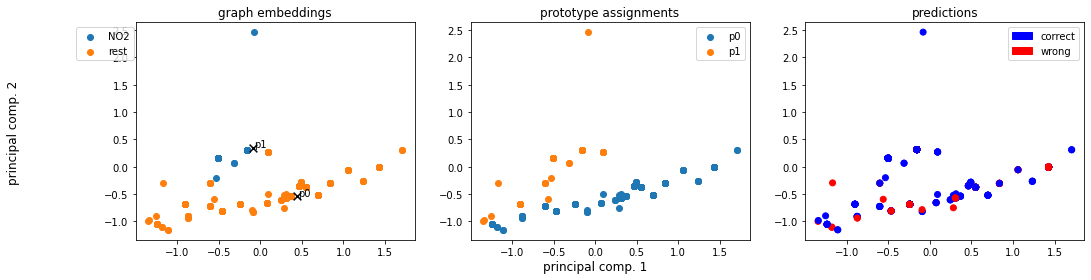

Alpha norms:
tensor([[0.7822, 1.0000],
        [1.0000, 0.4924]], grad_fn=<DivBackward0>)
Concept Purity: 0.980590 +- 0.019410
Concept distribution:  (array([0, 1], dtype=int64), array([375, 644], dtype=int64))
Logic formulas:
For class 0:
0.8379501385041551 (feature001) | ((feature000 & feature001)
For class 1:
0.8379501385041551 (feature000)
Accuracy as classifier:  0.838

200: Loss: 0.03806, LEN: 0.037535, AccxC: 0.84, AccO: 0.84, V. Acc: 0.87, V. Loss: 0.04639, V. LEN 0.04
201: Loss: 0.03853, LEN: 0.037812, AccxC: 0.83, AccO: 0.83, V. Acc: 0.87, V. Loss: 0.04628, V. LEN 0.04
202: Loss: 0.03810, LEN: 0.037518, AccxC: 0.84, AccO: 0.84, V. Acc: 0.87, V. Loss: 0.04695, V. LEN 0.04
203: Loss: 0.03838, LEN: 0.037850, AccxC: 0.84, AccO: 0.84, V. Acc: 0.88, V. Loss: 0.04368, V. LEN 0.04
204: Loss: 0.03823, LEN: 0.037692, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04327, V. LEN 0.04
205: Loss: 0.03724, LEN: 0.036728, AccxC: 0.84, AccO: 0.84, V. Acc: 0.88, V. Loss: 0.04295, V. LEN 0.0

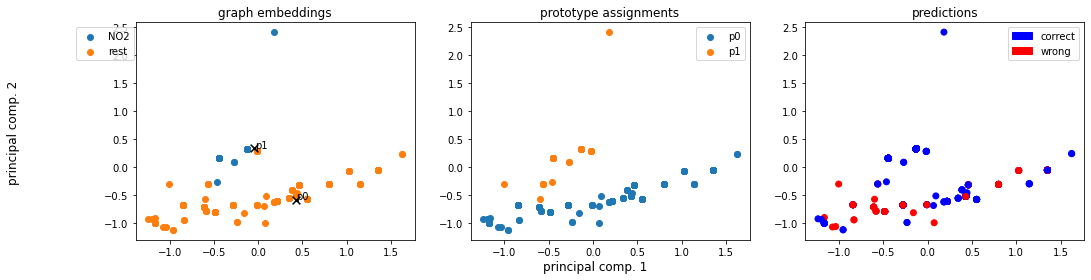

Alpha norms:
tensor([[0.7871, 1.0000],
        [1.0000, 0.5107]], grad_fn=<DivBackward0>)
Concept Purity: 0.991270 +- 0.008730
Concept distribution:  (array([0, 1], dtype=int64), array([389, 630], dtype=int64))
Logic formulas:
For class 0:
0.8296398891966759 (feature001) | ((feature000 & feature001)
For class 1:
0.8296398891966759 (feature000)
Accuracy as classifier:  0.8296

220: Loss: 0.03769, LEN: 0.037252, AccxC: 0.84, AccO: 0.84, V. Acc: 0.88, V. Loss: 0.04300, V. LEN 0.04
221: Loss: 0.03801, LEN: 0.037556, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04300, V. LEN 0.04
222: Loss: 0.03861, LEN: 0.038162, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04243, V. LEN 0.04
223: Loss: 0.03839, LEN: 0.037717, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04248, V. LEN 0.04
224: Loss: 0.03840, LEN: 0.037904, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04279, V. LEN 0.04
225: Loss: 0.03810, LEN: 0.037581, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04297, V. LEN 0.

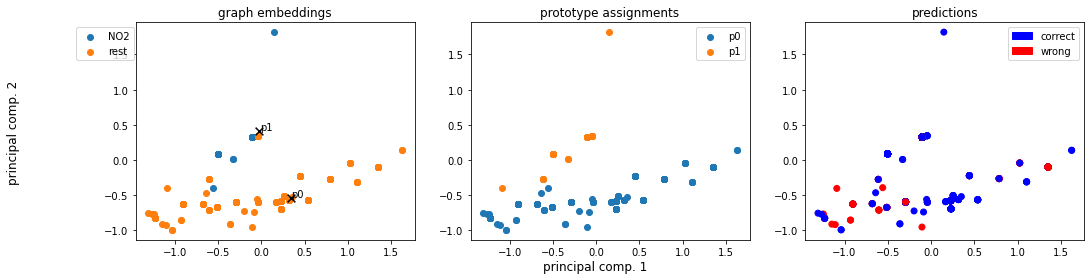

Alpha norms:
tensor([[0.7882, 1.0000],
        [1.0000, 0.5177]], grad_fn=<DivBackward0>)
Concept Purity: 0.990759 +- 0.006683
Concept distribution:  (array([0, 1], dtype=int64), array([391, 628], dtype=int64))
Logic formulas:
For class 0:
0.8296398891966759 (feature001) | ((feature000 & feature001)
For class 1:
0.8296398891966759 (feature000)
Accuracy as classifier:  0.8296

240: Loss: 0.03887, LEN: 0.038411, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04248, V. LEN 0.04
241: Loss: 0.03823, LEN: 0.037794, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04277, V. LEN 0.04
242: Loss: 0.03761, LEN: 0.037113, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04286, V. LEN 0.04
243: Loss: 0.03801, LEN: 0.037494, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04285, V. LEN 0.04
244: Loss: 0.03819, LEN: 0.037587, AccxC: 0.82, AccO: 0.82, V. Acc: 0.88, V. Loss: 0.04280, V. LEN 0.04
245: Loss: 0.03826, LEN: 0.037760, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04273, V. LEN 0.

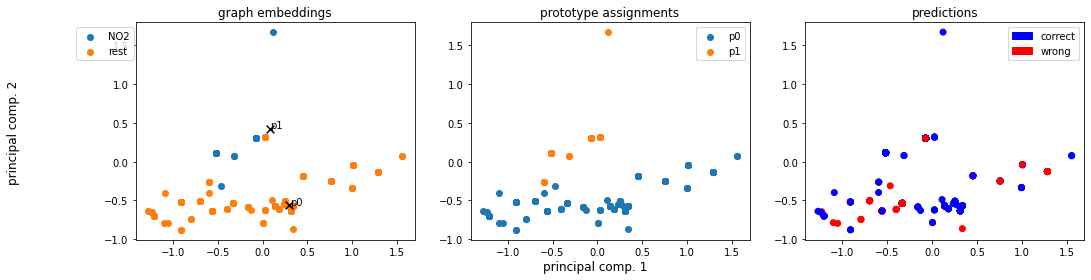

Alpha norms:
tensor([[0.8094, 1.0000],
        [1.0000, 0.5108]], grad_fn=<DivBackward0>)
Concept Purity: 0.991547 +- 0.005902
Concept distribution:  (array([0, 1], dtype=int64), array([392, 627], dtype=int64))
Logic formulas:
For class 0:
0.8310249307479224 (feature001) | ((feature000 & feature001)
For class 1:
0.8310249307479224 (feature000)
Accuracy as classifier:  0.831

260: Loss: 0.03881, LEN: 0.038327, AccxC: 0.82, AccO: 0.82, V. Acc: 0.88, V. Loss: 0.04374, V. LEN 0.04
261: Loss: 0.03857, LEN: 0.038142, AccxC: 0.82, AccO: 0.82, V. Acc: 0.88, V. Loss: 0.04318, V. LEN 0.04
262: Loss: 0.03801, LEN: 0.037632, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04216, V. LEN 0.04
263: Loss: 0.03868, LEN: 0.038302, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04185, V. LEN 0.04
264: Loss: 0.03837, LEN: 0.037983, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04177, V. LEN 0.04
265: Loss: 0.03939, LEN: 0.039005, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04215, V. LEN 0.0

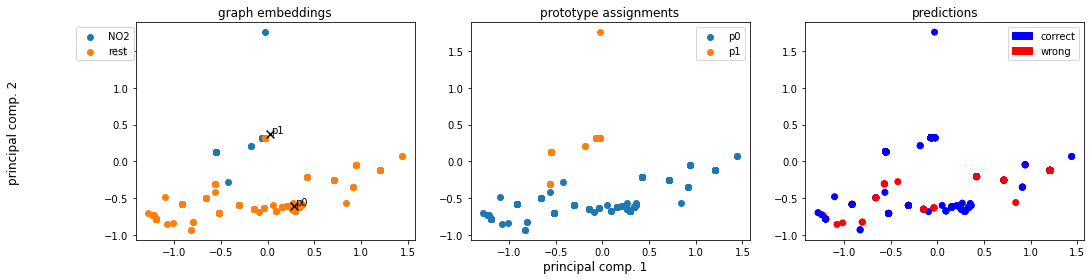

Alpha norms:
tensor([[0.8138, 1.0000],
        [1.0000, 0.5094]], grad_fn=<DivBackward0>)
Concept Purity: 0.991547 +- 0.005902
Concept distribution:  (array([0, 1], dtype=int64), array([392, 627], dtype=int64))
Logic formulas:
For class 0:
0.8310249307479224 (feature001) | ((feature000 & feature001)
For class 1:
0.8310249307479224 (feature000)
Accuracy as classifier:  0.831

280: Loss: 0.03829, LEN: 0.037863, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04264, V. LEN 0.04
281: Loss: 0.03865, LEN: 0.038231, AccxC: 0.82, AccO: 0.82, V. Acc: 0.88, V. Loss: 0.04314, V. LEN 0.04
282: Loss: 0.03808, LEN: 0.037682, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04291, V. LEN 0.04
283: Loss: 0.03885, LEN: 0.038470, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04286, V. LEN 0.04
284: Loss: 0.03822, LEN: 0.037840, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04296, V. LEN 0.04
285: Loss: 0.03930, LEN: 0.038972, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04338, V. LEN 0.0

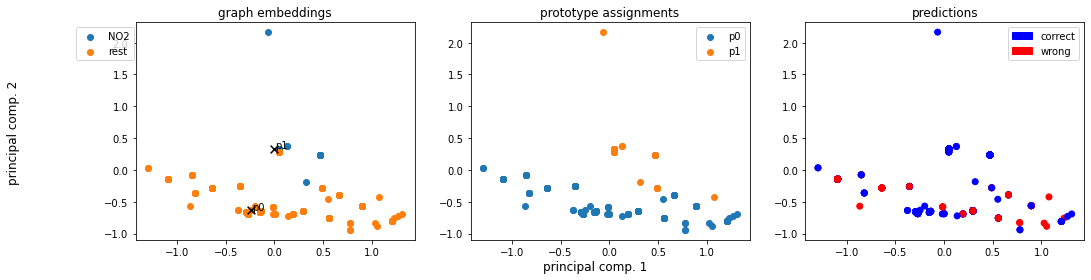

Alpha norms:
tensor([[0.8235, 1.0000],
        [1.0000, 0.5022]], grad_fn=<DivBackward0>)
Concept Purity: 0.992051 +- 0.007949
Concept distribution:  (array([0, 1], dtype=int64), array([390, 629], dtype=int64))
Logic formulas:
For class 0:
0.8310249307479224 (feature001) | ((feature000 & feature001)
For class 1:
0.8310249307479224 (feature000)
Accuracy as classifier:  0.831

300: Loss: 0.03906, LEN: 0.038701, AccxC: 0.82, AccO: 0.82, V. Acc: 0.88, V. Loss: 0.04204, V. LEN 0.04
301: Loss: 0.03824, LEN: 0.037902, AccxC: 0.82, AccO: 0.82, V. Acc: 0.88, V. Loss: 0.04203, V. LEN 0.04
302: Loss: 0.03902, LEN: 0.038606, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04200, V. LEN 0.04
303: Loss: 0.03807, LEN: 0.037720, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04203, V. LEN 0.04
304: Loss: 0.03883, LEN: 0.038391, AccxC: 0.82, AccO: 0.82, V. Acc: 0.88, V. Loss: 0.04235, V. LEN 0.04
305: Loss: 0.03809, LEN: 0.037750, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04235, V. LEN 0.0

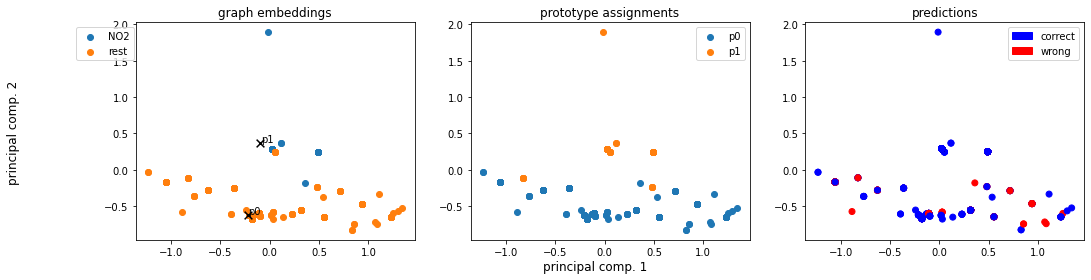

Alpha norms:
tensor([[0.8336, 1.0000],
        [1.0000, 0.5011]], grad_fn=<DivBackward0>)
Concept Purity: 0.987632 +- 0.009784
Concept distribution:  (array([0, 1], dtype=int64), array([387, 632], dtype=int64))
Logic formulas:
For class 0:
0.8310249307479224 (feature001) | ((feature000 & feature001)
For class 1:
0.8310249307479224 (feature000)
Accuracy as classifier:  0.831

320: Loss: 0.03858, LEN: 0.038285, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04293, V. LEN 0.04
321: Loss: 0.03945, LEN: 0.039110, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04323, V. LEN 0.04
322: Loss: 0.03718, LEN: 0.036873, AccxC: 0.84, AccO: 0.84, V. Acc: 0.88, V. Loss: 0.04293, V. LEN 0.04
323: Loss: 0.03847, LEN: 0.038121, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04229, V. LEN 0.04
324: Loss: 0.03671, LEN: 0.036380, AccxC: 0.85, AccO: 0.85, V. Acc: 0.88, V. Loss: 0.04203, V. LEN 0.04
325: Loss: 0.03766, LEN: 0.037286, AccxC: 0.84, AccO: 0.84, V. Acc: 0.88, V. Loss: 0.04210, V. LEN 0.0

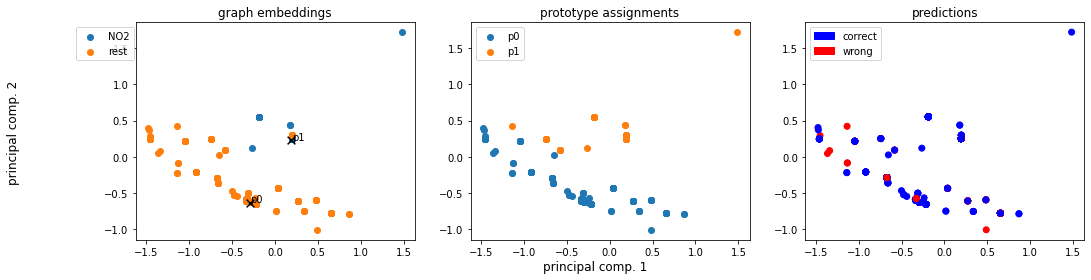

Alpha norms:
tensor([[0.8364, 1.0000],
        [1.0000, 0.5041]], grad_fn=<DivBackward0>)
Concept Purity: 0.987402 +- 0.012598
Concept distribution:  (array([0, 1], dtype=int64), array([384, 635], dtype=int64))
Logic formulas:
For class 0:
0.8351800554016621 (feature001) | ((feature000 & feature001)
For class 1:
0.8351800554016621 (feature000)
Accuracy as classifier:  0.8352

340: Loss: 0.03786, LEN: 0.037455, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04369, V. LEN 0.04
341: Loss: 0.03782, LEN: 0.037439, AccxC: 0.84, AccO: 0.84, V. Acc: 0.88, V. Loss: 0.04368, V. LEN 0.04
342: Loss: 0.03929, LEN: 0.038949, AccxC: 0.83, AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04741, V. LEN 0.05
343: Loss: 0.03861, LEN: 0.038265, AccxC: 0.83, AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04712, V. LEN 0.04
344: Loss: 0.03875, LEN: 0.038304, AccxC: 0.82, AccO: 0.82, V. Acc: 0.86, V. Loss: 0.04523, V. LEN 0.04
345: Loss: 0.03966, LEN: 0.039258, AccxC: 0.82, AccO: 0.82, V. Acc: 0.86, V. Loss: 0.04453, V. LEN 0.

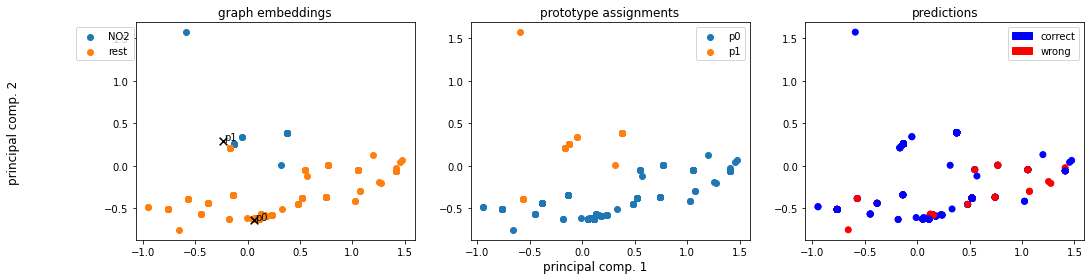

Alpha norms:
tensor([[0.8342, 1.0000],
        [1.0000, 0.5119]], grad_fn=<DivBackward0>)
Concept Purity: 0.992051 +- 0.007949
Concept distribution:  (array([0, 1], dtype=int64), array([390, 629], dtype=int64))
Logic formulas:
For class 0:
0.832409972299169 (feature001) | ((feature000 & feature001)
For class 1:
0.832409972299169 (feature000)
Accuracy as classifier:  0.8324

360: Loss: 0.03677, LEN: 0.036487, AccxC: 0.84, AccO: 0.84, V. Acc: 0.86, V. Loss: 0.04462, V. LEN 0.04
361: Loss: 0.03851, LEN: 0.038217, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04213, V. LEN 0.04
362: Loss: 0.03817, LEN: 0.037870, AccxC: 0.84, AccO: 0.84, V. Acc: 0.88, V. Loss: 0.04262, V. LEN 0.04
363: Loss: 0.03885, LEN: 0.038515, AccxC: 0.83, AccO: 0.83, V. Acc: 0.88, V. Loss: 0.04218, V. LEN 0.04
364: Loss: 0.03868, LEN: 0.038409, AccxC: 0.83, AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04454, V. LEN 0.04
365: Loss: 0.03901, LEN: 0.038730, AccxC: 0.83, AccO: 0.83, V. Acc: 0.86, V. Loss: 0.04497, V. LEN 0.04

In [42]:
batch_sampler = utils.GroupBatchSampler(num_input_graphs=128, drop_last=False, belonging=np.array(belonging_train))
train_group_loader = DataLoader(dataset_train, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_val))
val_group_loader = DataLoader(dataset_val, batch_sampler=batch_sampler)

batch_sampler = utils.GroupBatchSampler(num_input_graphs=256, drop_last=False, belonging=np.array(belonging_test))
test_group_loader = DataLoader(dataset_test, batch_sampler=batch_sampler)


torch.manual_seed(42)
hyper = {
    "len_lr": 0.0005,
    "proto_lr": 0.001,
    "le_emb_lr": 0.001,
    "coeff_divloss": 0.000,
    "coeff_pdist": 0.,
    "coeff_gae": 0.,
    "coeff_r1": 0.09,
    "coeff_r2": 0.00099,
    "coeff_ce": 0.0,
    "coeff_de": 0.,
    "coeff_logic_loss": 0.00,
    "focal_gamma": 2, #3
    "focal_alpha": -1,
    "ts": 1,
    "te": 1,
    "focal_loss": True,
    "debug_prototypes": False,
    "num_prototypes": 2,
    "dim_prototypes": 10,
    "num_le_features": 14,
    "activation": "leaky",
    "assign_func": "straight_sim",
    "LEN_temperature": 1,
    "remove_attention": True,
    "log_images": True,
    "log_models": False,
    "num_epochs": 500
}

len_model    = models.LEN(hyper["num_prototypes"], 
                          hyper["LEN_temperature"], 
                          remove_attention=hyper["remove_attention"]).to(device)
le_model     = models.LEEmbedder(num_features=hyper["num_le_features"], 
                                 activation=hyper["activation"], 
                                 num_hidden=hyper["dim_prototypes"]).to(device)
expl         = models.GlobalExplainer(len_model, 
                               le_model, 
                               train_group_loader, 
                               val_group_loader, 
                               device, 
                               hyper_params=hyper,
                               classes_names=mutag_classes_names,
                               dataset_name=DATASET_NAME).to(device)

prefix = "DEBUG" if hyper["debug_prototypes"] else ""
suffix = "no attn" if hyper["remove_attention"] else ""
expl.iterate(num_epochs=hyper["num_epochs"], log_wandb=False, name_wandb=f"MUTAG {hyper['num_prototypes']}prots {prefix} {suffix}")

(array([0., 1.], dtype=float32), array([65, 54], dtype=int64))
[0.6532005  0.28568286]


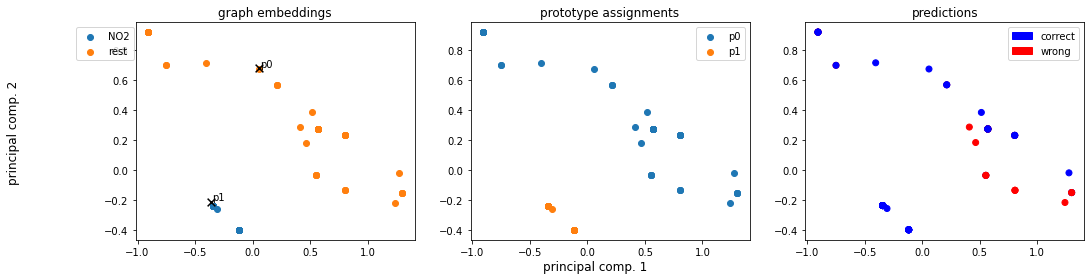

Alpha norms:
tensor([[0.8041, 1.0000],
        [1.0000, 0.5157]], grad_fn=<DivBackward0>)
Concept Purity: 1.000000 +- 0.000000
Concept distribution:  (array([0, 1], dtype=int64), array([54, 65], dtype=int64))
Logic formulas:
For class 0:
0.8452380952380952 (feature001) | ((feature000 & feature001)
For class 1:
0.8452380952380952 (feature000)
Accuracy as classifier:  0.8452



In [45]:
expl.inspect_embedding(test_group_loader)